In [1]:
import best

In [80]:
import best_jax as bestj

In [2]:
import scipy

In [3]:
from scipy import optimize

In [4]:
import matplotlib.pyplot as plt

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

In [6]:
import numpy as np

In [7]:
import pathlib

In [8]:
import yaml

In [9]:
import utilities as u
import itertools

In [10]:
import pandas

In [86]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev

In [12]:
filteredcase = False

In [45]:
values_file = 'configurations/configILC.yaml' if filteredcase else 'configurations/configILC.yaml'
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)
values_file

'configurations/configILC.yaml'

In [46]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())

estimatorssub = data['estimatorssubset']

if estimatorssub != '':
    estimators = estimatorssub

lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [15]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [16]:
lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [17]:
lref_ = 3500
reference_directory = pathlib.Path('output_ILC_1503')/f'h{lref_}s{lref_}b{lref_}p{lref_}sy{lref_}sybh{lref_}/total/'

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises_high = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy', 'sybh']
Optimizerkk_high = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises_high)

In [18]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [19]:
Optimizerkk = Optimizerkk_high
x_estimator = get_est_weights(Optimizerkk, index = 0)
f, n, b = fnb_getter(Optimizerkk, 1., True)
f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)

In [20]:
all_ref = [f_ref, n_ref, b_ref]
all_ref

[0.0008459729944576088, 0.006859550712226799, 0.02826516510625752]

In [21]:
def get_dir_function(names):
    def get_dir_(*vals):
        stringa = ''
        for i, k in enumerate(names.keys()):
            num = vals[i]
            v = names[k]
            stringa += f'{v}{num}'
        return stringa
    return get_dir_

In [22]:
get_dir = get_dir_function(names)

In [23]:
get_dir(4500, 4500, 4500, 4500)

's4500b4500p4500'

In [24]:
reference_directory = pathlib.Path(analysis_directory)/f'{get_dir(4500, 4500, 4500, 4500)}/total/'
noises = np.load(reference_directory/'N_total_ilc.npy')
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
Optimizerkk__ = best.Opt(['s', 'b', 'p', 'sy'], lmin_sel, lmax_sel, ells, kk, theta, biases, noises)

In [25]:
estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())
if estimatorssub != '':
    estimators = estimatorssub
estimators

['shear', 'bh', 'pbh']

In [26]:
analysis_directory = data['analysisdirectory']
PP = pathlib.Path(analysis_directory)
PP

PosixPath('output_ILC')

In [27]:
l = 3500
lista = [l]*len(estimators)

In [28]:
kk = np.load(pathlib.Path(analysis_directory)/get_dir(*lista)/'kk_ilc.npy')
theta = np.load(pathlib.Path(analysis_directory)/get_dir(*lista)/'theta_ilc.npy')
ells = np.load(pathlib.Path(analysis_directory)/get_dir(*lista)/'ells_ilc.npy')
selection = (ells > 30) & (ells < 1200)

In [29]:
def get_info(directory, resultspath, fb = 1.0):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/f'w_auto_fb_{fb}.npy')
    x = np.load(resultspath/directory/f'x_auto_fb_{fb}.npy')
    return kk, theta, ells, biases, noises, w, x

In [30]:
def make_table(resultsdir, all_lmaxes_directories, names, fb = 0., crosstag = None, optimtag = None, all_ref = None, autoname = 'Auto', include_estimators = True, include_dirs = True, include_ref = False, extradir = ''):
    data = {}
    if include_dirs:
        data['Name'] = all_lmaxes_directories
    superarray = np.zeros((3, 1+len(names), len(all_lmaxes_directories)))
    for i, direc in enumerate(all_lmaxes_directories):
        try:
            results_array = np.load(resultsdir/direc/extradir/f'alens_{fb}{crosstag}{optimtag}.npy')
            superarray[:, :, i] = results_array
        except:
            print(f'Skip {direc} for {fb}')
        
    data[f'Total {autoname}'] = superarray[0, 0]
    data[f'Noise {autoname}'] = superarray[1, 0]
    data[f'Bias {autoname}'] = superarray[2, 0]
    
    if include_ref:
        data[f'Noise {autoname} rtr'] = superarray[1, 0]/all_ref[1]
        data[f'Bias {autoname} rtr'] = superarray[2, 0]/all_ref[2]
        
    if include_estimators:
        for i, n in enumerate(names):
            #data[f'Total {n} rtr'] = superarray[0, i]/all_ref[0]
            data[f'Noise {n} rtr'] = superarray[1, i]/all_ref[1]
            data[f'Bias {n} rtr'] = superarray[2, i]/all_ref[2]
    
    return pandas.DataFrame(data)

In [31]:
path = pathlib.Path(results_directory)
l = 3500
all_lmaxes_directories=  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(*lista))]



In [32]:
results_directory

'resultssumfg_ILC/'

In [33]:
all_lmaxes_directories

['s4500b4500p3000',
 's4500b4500p4500',
 's3500b3500p4500',
 's4000b3500p3000',
 's4000b4000p3500',
 's3000b3500p4000',
 's4500b3500p3000',
 's3500b3000p4500',
 's4000b3500p3500',
 's4500b3500p4000',
 's3500b4500p3500',
 's3000b3000p3000',
 's3500b3500p4000',
 's3000b3000p3500',
 's4000b3000p3000',
 's4000b3000p4000',
 's3000b4000p3000',
 's3500b3000p3500',
 's3000b4000p4000',
 's4500b3500p3500',
 's3000b3500p4500',
 's3000b4000p4500',
 's3500b4000p3000',
 's4500b4000p4500',
 's3000b4000p3500',
 's4500b4000p3500',
 's3500b3500p3500',
 's3500b4500p3000',
 's4000b4000p4500',
 's3500b4000p4000',
 's4000b3500p4500',
 's3500b3500p3000',
 's4000b4000p3000',
 's4500b3000p4000',
 's4500b4500p3500',
 's3000b3500p3500',
 's4500b3000p3000',
 's4500b4000p4000',
 's3000b3000p4500',
 's4000b3000p4500',
 's3500b3000p4000',
 's4500b3000p4500',
 's4000b3500p4000',
 's4500b4500p4000',
 's3000b4500p4500',
 's3000b3000p4000',
 's4000b4500p4500',
 's3500b4500p4500',
 's3500b4500p4000',
 's3500b3000p3000',


In [47]:
fbs = data['optimisation']['fbs']
fbs = np.sort(fbs, ).astype(float)

In [48]:
fbs

array([ 0.,  1.,  4.,  9., 16., 32.])

In [49]:
#fbs = np.array([0., 0.01, 0.1, 0.2, 0.4, 0.5, 0.7, 1.])

In [50]:
import matplotlib.cm as cm
colors_plotting = cm.rainbow(np.linspace(0, 1, len(fbs)))

## Check one fixed configuration

In [51]:
all_lmaxes_directories[0]

's4500b4500p3000'

In [52]:
resultsdir

PosixPath('resultssumfg_ILC')

In [53]:
fbs

array([ 0.,  1.,  4.,  9., 16., 32.])

No handles with labels found to put in legend.


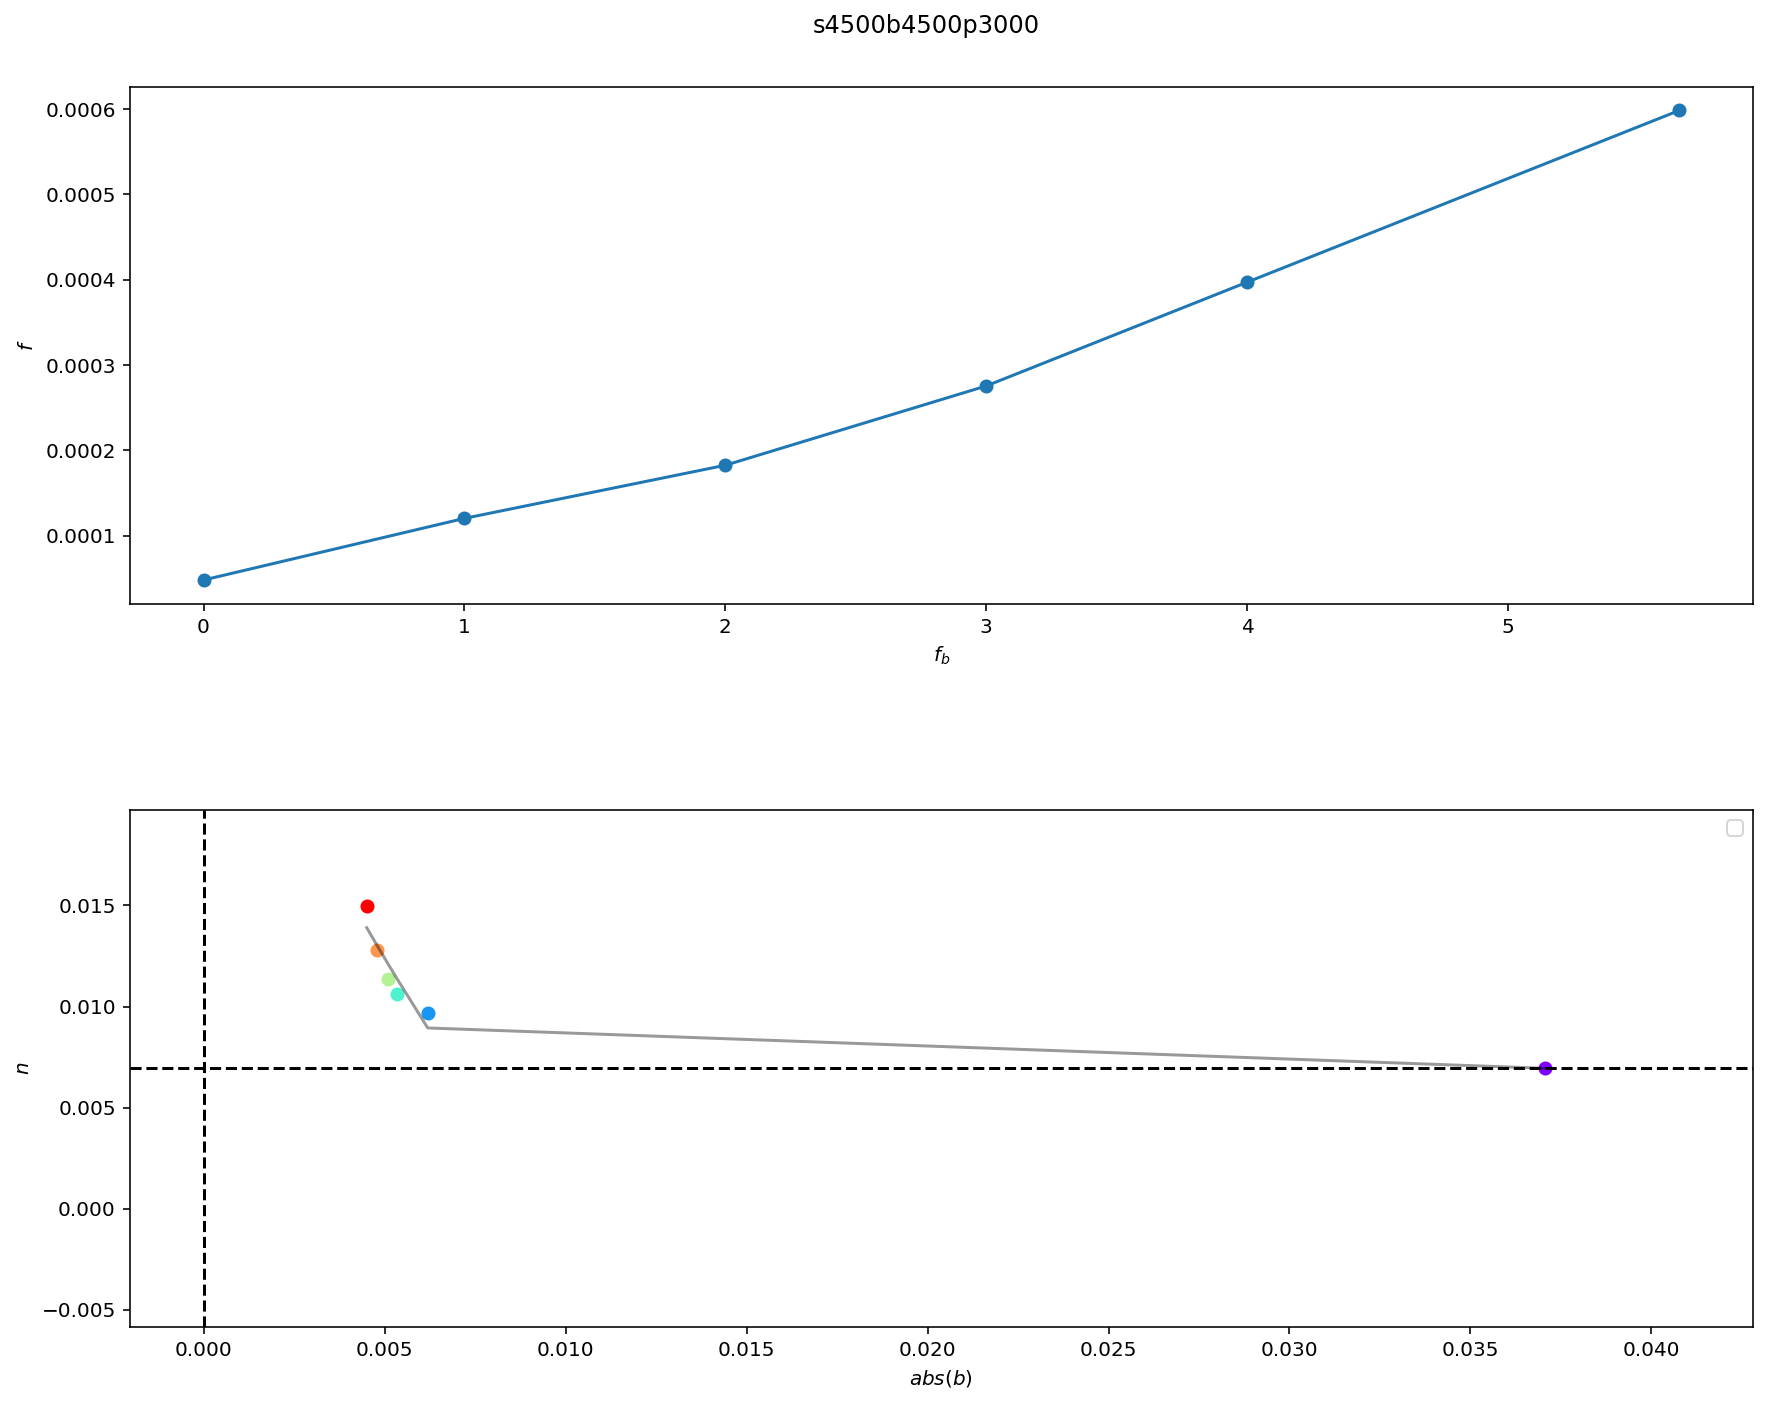

In [64]:
direc = all_lmaxes_directories[0]
resultsdir = pathlib.Path(results_directory)
flist = []
blist = []
nlist = []

flist_ofoptim = []
blist_ofoptim = []
nlist_ofoptim = []

for fb in fbs:
    results_array = np.load(resultsdir/direc/f'alens_{fb}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    flist += [ftemp]
    nlist += [ntemp]
    blist += [btemp]
    
    results_array = np.load(resultsdir/direc/f'alens_{fb}_ofoptim.npy')[:, 0]
    ftemp, _, btemp = results_array
    flist_ofoptim += [ftemp]
    nlist_ofoptim += [ntemp]
    blist_ofoptim += [btemp]
    
flist = np.array(flist)
nlist = np.array(nlist)
blist = np.array(blist)

flist_ofoptim = np.array(flist_ofoptim)
blist_ofoptim = np.array(blist_ofoptim)
nlist_ofoptim = np.array(nlist_ofoptim)

fig, axs = plt.subplots(nrows = 2, figsize = (12, 10), sharex = False)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.suptitle(direc)
fig.subplots_adjust(hspace = 0.4)


axs[0].plot(np.sqrt(fbs), flist, marker = 'o')
axs[0].set_ylabel('$f$')
axs[0].set_xlabel('$f_b$')

coeffs = np.polyfit(blist_ofoptim, nlist_ofoptim, 2)
p = np.poly1d(coeffs)

#axs[1].scatter(abs(blist), nlist)
for i, fb in enumerate(fbs):
    #axs[1].scatter(abs(blist)[i], nlist[i], color = colors_plotting[i], label = np.round(np.sqrt(fb), 2))
    axs[1].scatter(abs(blist_ofoptim)[i], nlist_ofoptim[i], color = colors_plotting[i])
    #axs[1].annotate(fb, (abs(blist)[i], nlist[i]))
    
axs[1].plot(blist_ofoptim, p(blist_ofoptim), color = 'black', alpha = 0.4)

axs[1].legend(ncol = len(fbs))
axs[1].axhline(nlist[0], ls = '--', color = 'black')
axs[1].axvline(0., ls = '--', color = 'black')
axs[1].set_ylabel('$n$')
axs[1].set_xlabel('$abs(b)$')


plt.show()

In [70]:
fb = 0.

In [585]:
kk, theta, ells, biases, noises, w, x = get_info(direc, resultsdir, fb = fb)
Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = False)
filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
Optimizerkk = bestj.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected, nocrosses = False)              

In [82]:
resultkk = best.Res()
resultkk.load_all(resultsdir/direc, f'auto_fb_{fb}')

In [83]:
xx = resultkk.x

In [84]:
f, n, b = fnb_getter(Optimizerkk, fb, False)

In [93]:
ff = jit(f)

In [95]:
gff = grad(ff)

In [117]:
def ffunction(fbselected):
    _, n, b = fnb_getter(Optimizerkk, fbselected, False)
    return n(xx)**2+fbselected*b(xx)**2

In [118]:
gffunction = grad(ffunction)

In [121]:
gffunction(1.)

DeviceArray(0.00137409, dtype=float32)

In [120]:
ffunction(0.)

DeviceArray(4.8172788e-05, dtype=float32)

In [173]:
def getwL(Opt, fb, x, ws, invvariance = False):
    
    a = Opt.get_a(x, invvariance)
    wl = ws[:, -1]
    
    combinedb = Opt.get_bias_part(a, Opt.biases_selected)
    combinedtheta = Opt.get_variance_part(a, Opt.theta_selected)
    
    kk = Opt.theory_selected
    
    integrandkk = kk**2/combinedtheta
    integrand = combinedb*kk/combinedtheta
    factor = Opt.integerate_discrete(integrand, Opt.ells_selected)
    factorkk = Opt.integerate_discrete(integrandkk, Opt.ells_selected)
    
    part = fb*factor**2/(1+fb*factor)
    
    mvsolunnorm = kk**2/combinedtheta
    result = mvsolunnorm*1/(factorkk-part)*(1-fb*combinedb/kk*factor/(1+fb*factor))
    
    return result, mvsolunnorm*1/(factorkk-part), (1-fb*combinedb/kk*factor/(1+fb*factor))

### MV solution works

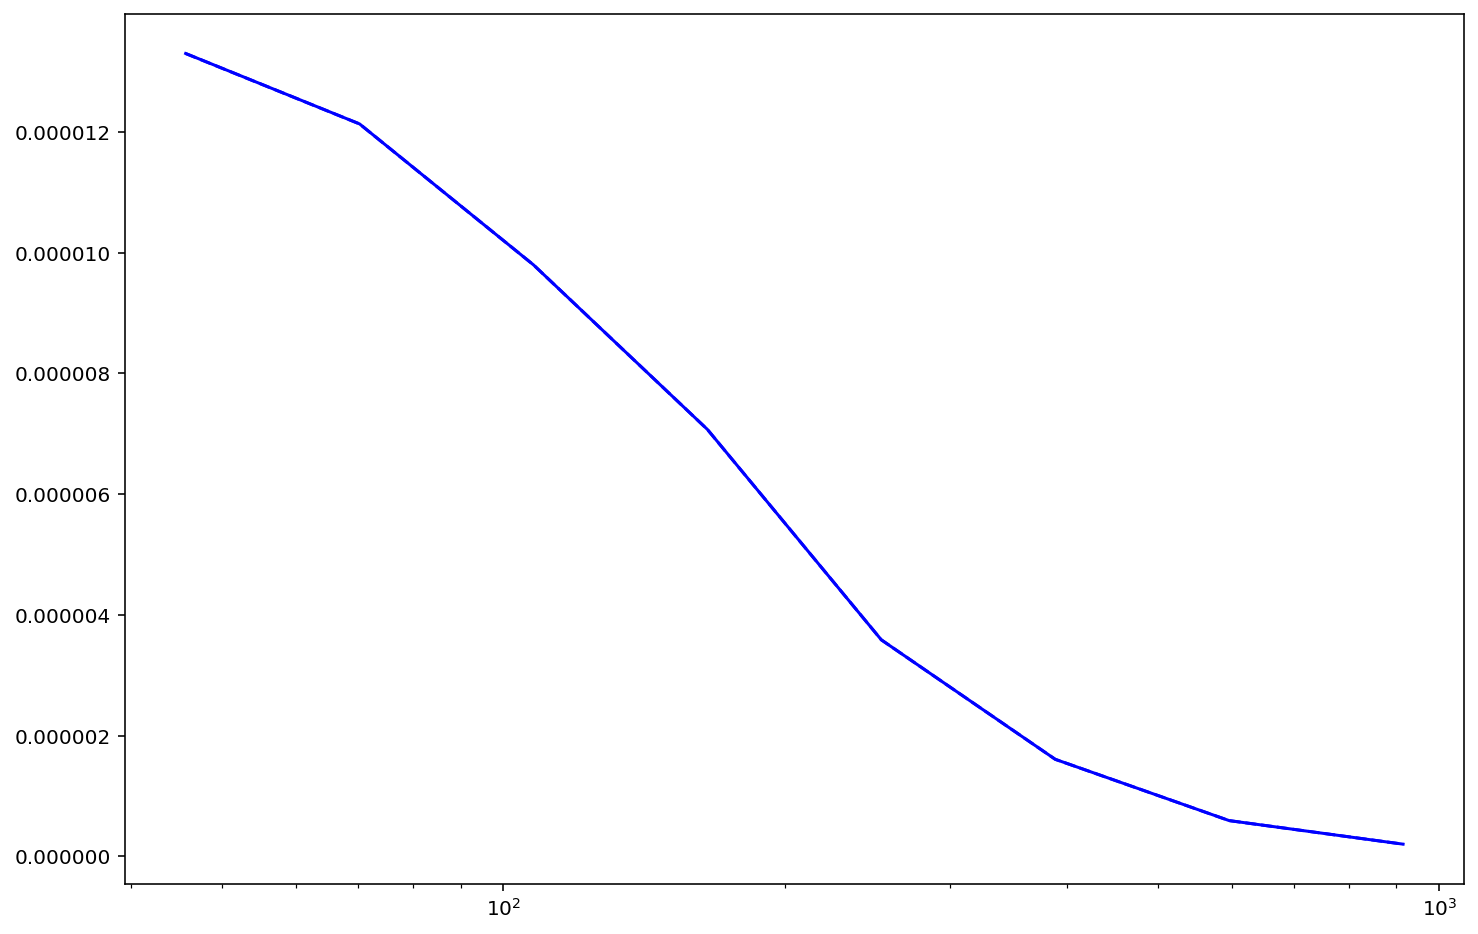

In [174]:
fb = 0.

resultkk = best.Res()
resultkk.load_all(resultsdir/direc, f'auto_fb_{fb}')

plt.plot(Optimizerkk.ells_selected, getwL(Optimizerkk, fb, resultkk.x, resultkk.ws)[0], color = 'b')
plt.plot(Optimizerkk.ells_selected, resultkk.ws[:, -1], ls = '--', color = 'b')
plt.xscale('log')

### Other solutions

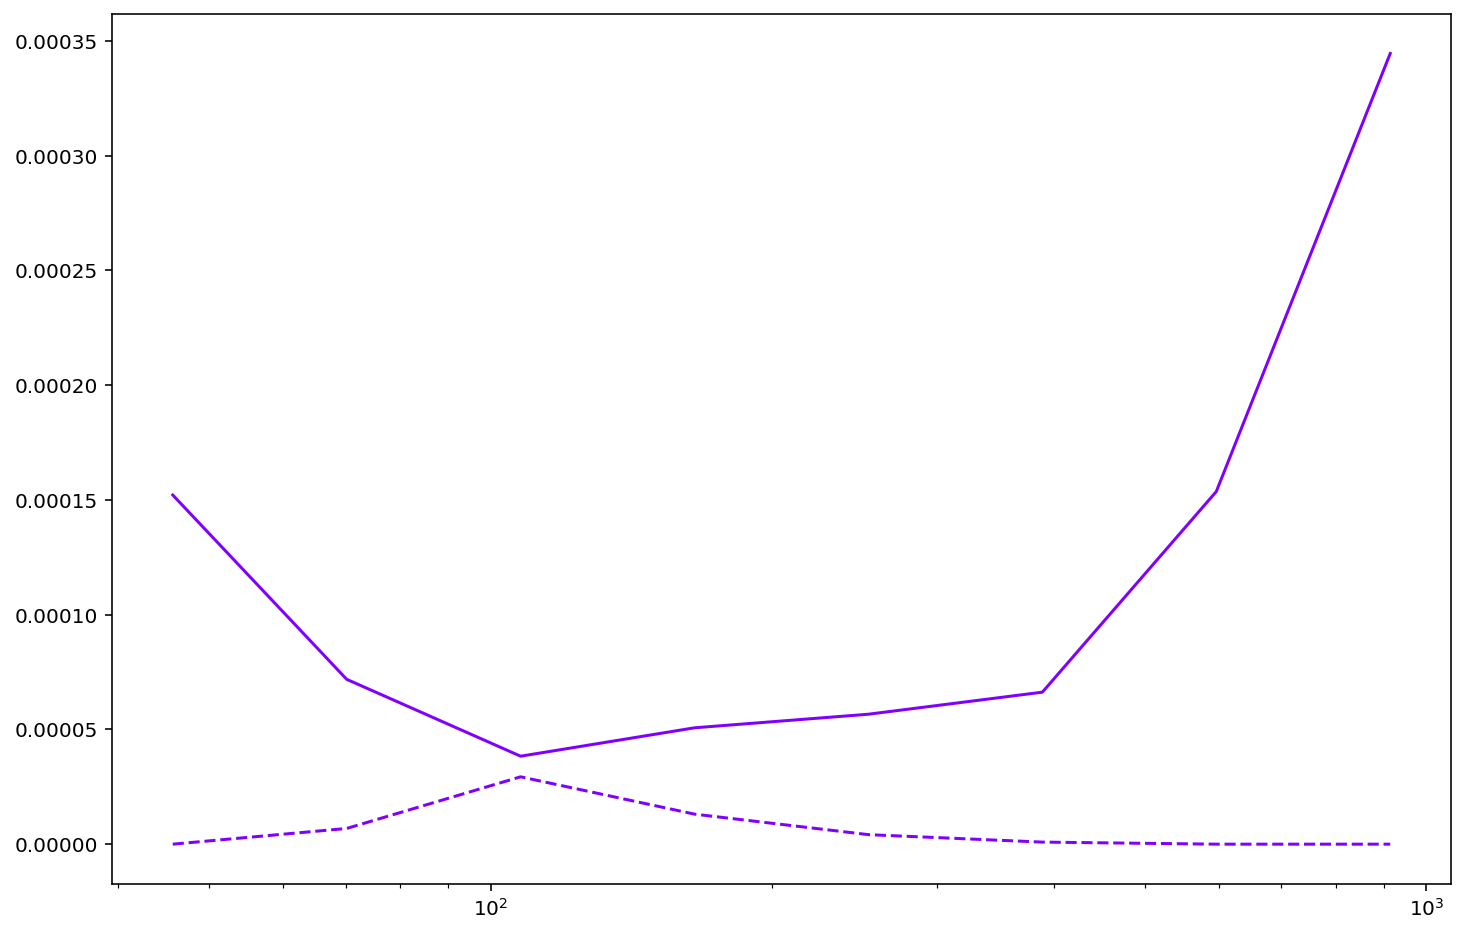

In [168]:
fb = 9.
resultkk = best.Res()
resultkk.load_all(resultsdir/direc, f'auto_fb_{fb}')

#plt.plot(Optimizerkk.ells_selected, getwL(Optimizerkk, fb, resultkk.x, resultkk.ws)[0], color = 'b')
for i, fb in enumerate([9.]):
    resultkk.load_all(resultsdir/direc, f'auto_fb_{fb}')
    plt.plot(Optimizerkk.ells_selected, resultkk.ws[:, -1], ls = '--', color = colors_plotting[i])
    
    a = Opt.get_a(resultkk.x, invvariance)
    combinedb = Opt.get_bias_part(a, Opt.biases_selected)
    plt.plot(Optimizerkk.ells_selected, combinedb/kk*1e-2, color = colors_plotting[i])
    
plt.xscale('log')

plt.show()

In [677]:
Opt = Optimizerkk

fb = 16.

resultkk = best.Res()
resultkk.load_all(resultsdir/direc, f'auto_fb_{fb}')

x = resultkk.x

ws = resultkk.ws

invvariance = False

a = Opt.get_a(x, invvariance)
wl = ws[:, -1]

combinedb = Opt.get_bias_part(a, Opt.biases_selected)
combinedtheta = Opt.get_variance_part(a, Opt.theta_selected)

kk = Opt.theory_selected

integrandkk = kk**2/combinedtheta
integrand = combinedb*kk/combinedtheta
integrandbb = combinedb**2/combinedtheta
factor = Opt.integerate_discrete(integrand, Opt.ells_selected)
factorkk = Opt.integerate_discrete(integrandkk, Opt.ells_selected)
factorbb = Opt.integerate_discrete(integrandbb, Opt.ells_selected)

part = fb*factor**2/(1+fb*factor)

mvsolunnorm = kk**2/combinedtheta

X = factor/factorkk
Y = factor
Z = factorbb
mvsol = mvsolunnorm/factorkk

bcalculated = X/(1+fb*Z-fb*X*Y)
result = mvsol*(1+fb*bcalculated*Y)-fb*bcalculated*integrand

#mvsol+fb*(X/(1+fb*Z-fb*X*Y))*(mvsol*Y-combinedb*kk/combinedtheta)


f, n, b = fnb_getter(Optimizerkk, fb, False)

b = b(x)

result2 = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand


selection = np.where(result2 < 0)
selectionnot = np.where(result2 > 0)

int1 = Opt.integerate_discrete((kk**2/combinedtheta)[selectionnot], Opt.ells_selected[selectionnot])
int1special = Opt.integerate_discrete(1, Opt.ells_selected[selection])
int2 = Opt.integerate_discrete(((kk**2/combinedtheta)*combinedb/kk)[selectionnot], Opt.ells_selected[selectionnot])
int2special = Opt.integerate_discrete((combinedb/kk)[selection], Opt.ells_selected[selection])
lambda_over_2 = 1/(int1)*(1-fb*b*(int2))
mu_over_2 = (fb*b*combinedb/kk-lambda_over_2)*(result2 < 0)
result3 = (lambda_over_2+mu_over_2)*kk**2/combinedtheta-fb*b*combinedb/kk*kk**2/combinedtheta



'''
selection = np.where(result3 != 0)
selectionnot = result3 != 0


factor = Opt.integerate_discrete(integrand[selection], Opt.ells_selected[selection])
factorkk = Opt.integerate_discrete(integrandkk[selection], Opt.ells_selected[selection])

result2 = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand
result2 *= selectionnot


selection = np.where(result2>0)
selectionnot = result2>0


factor = Opt.integerate_discrete(integrand[selection], Opt.ells_selected[selection])
factorkk = Opt.integerate_discrete(integrandkk[selection], Opt.ells_selected[selection])

result2 = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand
result2 *= selectionnot
'''

'\nselection = np.where(result3 != 0)\nselectionnot = result3 != 0\n\n\nfactor = Opt.integerate_discrete(integrand[selection], Opt.ells_selected[selection])\nfactorkk = Opt.integerate_discrete(integrandkk[selection], Opt.ells_selected[selection])\n\nresult2 = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand\nresult2 *= selectionnot\n\n\nselection = np.where(result2>0)\nselectionnot = result2>0\n\n\nfactor = Opt.integerate_discrete(integrand[selection], Opt.ells_selected[selection])\nfactorkk = Opt.integerate_discrete(integrandkk[selection], Opt.ells_selected[selection])\n\nresult2 = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand\nresult2 *= selectionnot\n'

In [678]:
result

DeviceArray([ 6.7134897e-06,  2.2602790e-05,  2.3903511e-05,
              1.3842008e-05,  5.2599535e-06,  1.8277415e-06,
             -4.1124224e-07, -3.2990135e-07], dtype=float32)

In [692]:
def get_weight_per_l_analytical_internal(self, x, invvariance, selection):
    
    a = self.get_a(x, invvariance)
    
    combinedb = self.get_bias_part(a, self.biases_selected)
    combinedtheta = Opt.get_variance_part(a, self.theta_selected)

    kk = self.theory_selected

    integrandkk = kk**2/combinedtheta
    integrand = combinedb*kk/combinedtheta
    integrandbb = combinedb**2/combinedtheta
    factor = self.integerate_discrete(integrand*selection, self.ells_selected)
    factorkk = self.integerate_discrete(integrandkk*selection, self.ells_selected)
    factorbb = self.integerate_discrete(integrandbb*selection, self.ells_selected)

    part = fb*factor**2/(1+fb*factor)

    mvsolunnorm = kk**2/combinedtheta

    X = factor/factorkk
    Y = factor
    Z = factorbb
    mvsol = mvsolunnorm/factorkk

    bcalculated = X/(1+fb*Z-fb*X*Y)
    result__ = mvsol*(1+fb*bcalculated*Y)-fb*bcalculated*integrand
    
    return result__


def get_weight_per_l_analytical(self, x, invvariance):
    
    selection = (self.ells_selected >= self.lmin_sel) & (self.ells_selected <= self.lmax_sel)
    
    result__ = get_weight_per_l_analytical_internal(self, x, invvariance, selection)
    
    while not(np.all(result__>=0)):
    
        selection = np.where(result__>0)
        selectionnot = result__>0        
        result__ = get_weight_per_l_analytical_internal(self, x, invvariance, selectionnot)        
        result__ *= selectionnot

        norma = self.integerate_discrete(result__, self.ells_selected)
        print(result__, norma)
        
    return result__

In [693]:
result__ = get_weight_per_l_analytical(Optimizerkk, x, False)

[-9.9555233e-05 -6.6507346e-07  3.6142606e-05  1.5336464e-05
  4.6429805e-06  8.4151543e-07 -0.0000000e+00 -0.0000000e+00] 0.99999934
[-0.0000000e+00 -0.0000000e+00  3.7449532e-05  1.4397592e-05
  3.9269762e-06  3.5870835e-07 -0.0000000e+00 -0.0000000e+00] 1.0000002


In [623]:
resultkk.ws[:, -1]

array([1.09131851e-05, 1.81780214e-05, 1.70252025e-05, 1.01378086e-05,
       3.91144145e-06, 1.39764249e-06, 2.63187724e-07, 9.21570896e-21])

In [642]:
not(True or True)

False

In [624]:
np.all(result2__>=0)

DeviceArray(True, dtype=bool)

In [625]:
print(result2)

[ 1.1283866e-05  1.8507133e-05  1.7274266e-05  1.0297439e-05
  3.9753636e-06  1.4219809e-06  2.7117599e-07 -6.0415005e-08]


In [626]:
result2__ = result2

while not(np.all(result2__>=0)):
    
    selection = np.where(result2__>0)
    selectionnot = result2__>0

    factor = Opt.integerate_discrete(integrand[selection], Opt.ells_selected[selection])
    factorkk = Opt.integerate_discrete(integrandkk[selection], Opt.ells_selected[selection])

    result2__ = 1/factorkk*(1+fb*factor*b)*kk**2/combinedtheta-fb*b*integrand
    result2__ *= selectionnot
    
    print(result2__)
    
nnnn = Opt.integerate_discrete(result2__, Opt.ells_selected)
result2__ /= nnnn

[ 1.2065035e-05  1.9200730e-05  1.7799153e-05  1.0633854e-05
  4.1100784e-06  1.4732721e-06  2.8801074e-07 -0.0000000e+00]


In [627]:
f, n, b = fnb_getter(Optimizerkk, fb, False)
b(x)

DeviceArray(0.00619338, dtype=float32)

In [628]:
xx = x.copy()
xx[-Optimizerkk.nbins:] = result2__
b(xx)

DeviceArray(0.00622416, dtype=float32)

In [629]:
result2__

DeviceArray([ 1.1439074e-05,  1.8204555e-05,  1.6875694e-05,
              1.0082146e-05,  3.8968387e-06,  1.3968355e-06,
              2.7306811e-07, -0.0000000e+00], dtype=float32)

In [630]:
resultkk.ws[:, -1]

array([1.09131851e-05, 1.81780214e-05, 1.70252025e-05, 1.01378086e-05,
       3.91144145e-06, 1.39764249e-06, 2.63187724e-07, 9.21570896e-21])

In [631]:
(result2__-resultkk.ws[:, -1])/resultkk.ws[:, -1]

DeviceArray([ 4.8188400e-02,  1.4596527e-03, -8.7815812e-03,
             -5.4905345e-03, -3.7333670e-03, -5.7736452e-04,
              3.7541192e-02, -1.0000000e+00], dtype=float32)

In [685]:
(result__-resultkk.ws[:, -1])/resultkk.ws[:, -1]

DeviceArray([-1.0000000e+00, -1.0000000e+00,  1.9428708e-07,
             -6.3169928e-08, -4.6320346e-07,  0.0000000e+00,
             -1.0000000e+00, -1.0000000e+00], dtype=float32)

In [633]:
Opt.integerate_discrete(result2__, Opt.ells_selected)

DeviceArray(0.9999999, dtype=float32)

In [634]:
Opt.integerate_discrete(result__, Opt.ells_selected)

DeviceArray(1.0000001, dtype=float32)

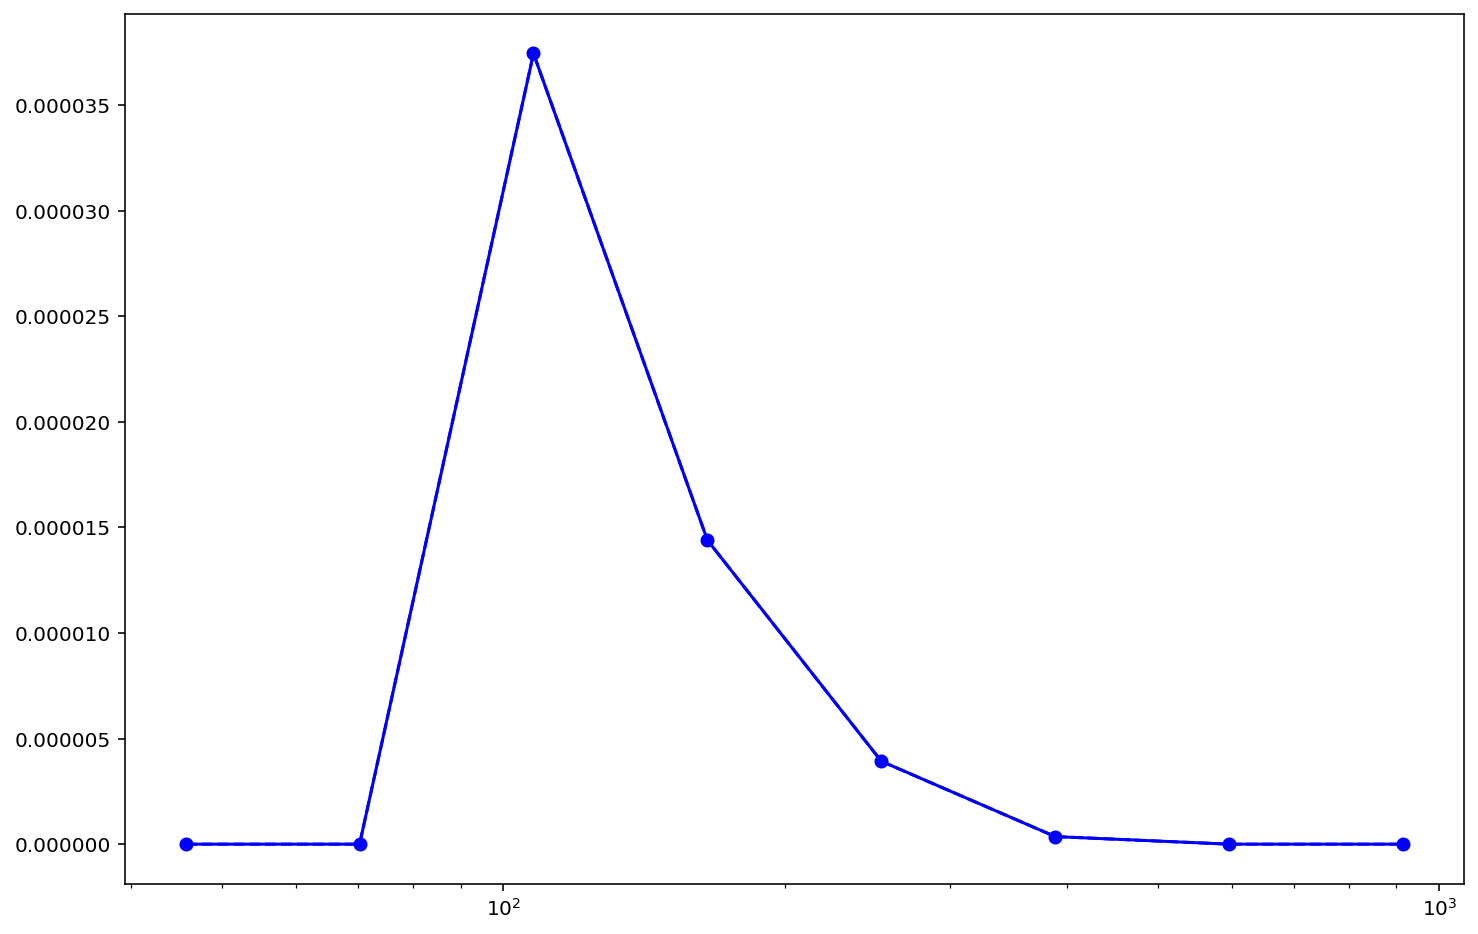

In [686]:
plt.plot(Optimizerkk.ells_selected, result__, color = 'b', marker = 'o')
#plt.plot(Optimizerkk.ells_selected, result2__, color = 'b')
plt.plot(Optimizerkk.ells_selected, resultkk.ws[:, -1], ls = '--', color = 'b')
plt.xscale('log')

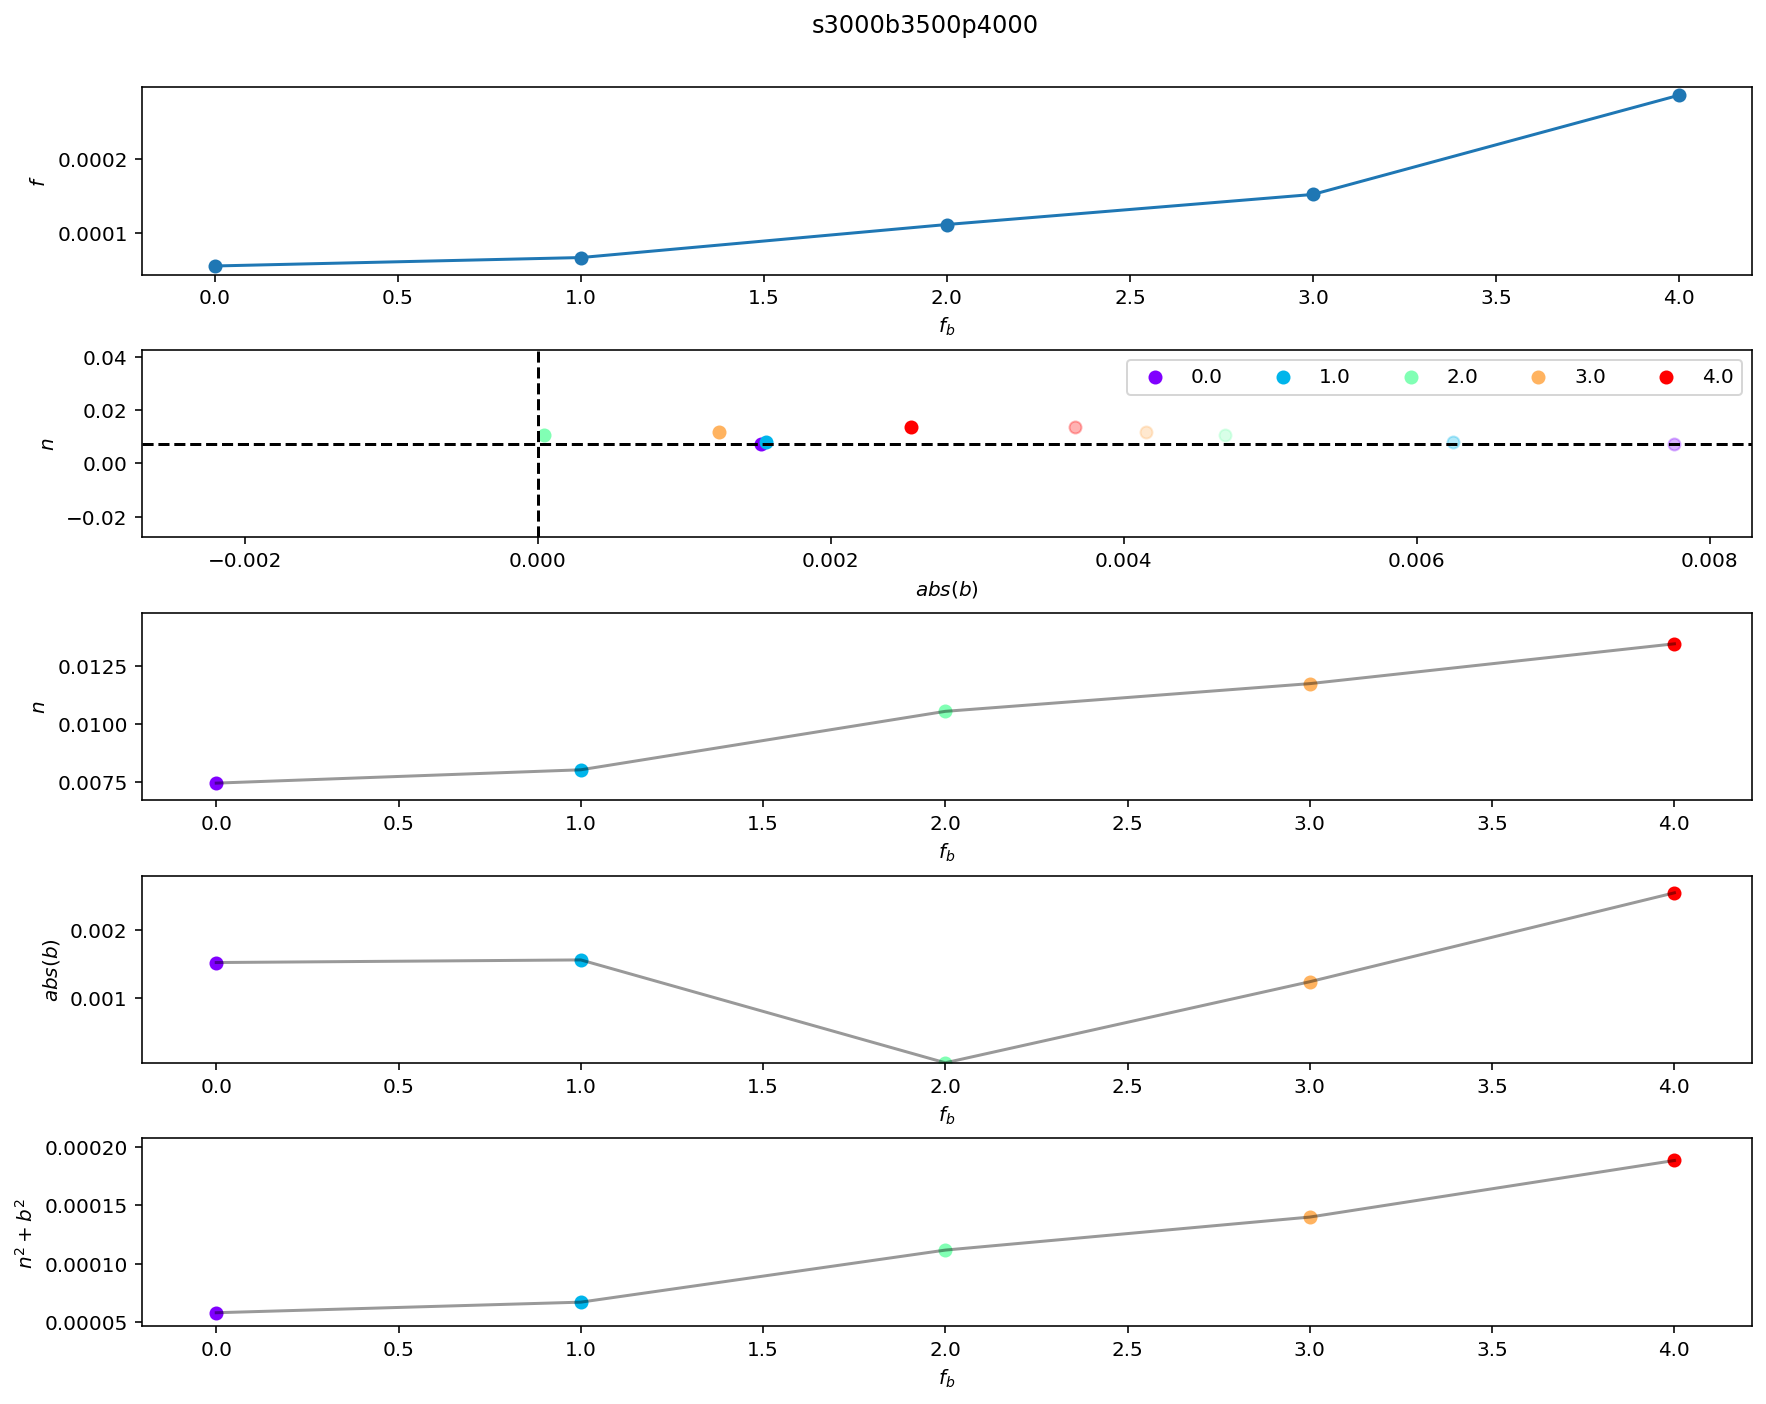

In [75]:
direc = all_lmaxes_directories[0]
resultsdir = pathlib.Path(results_directory)
flist = []
blist = []
nlist = []

flist_ofoptim = []
blist_ofoptim = []
nlist_ofoptim = []

for fb in fbs:
    results_array = np.load(resultsdir/direc/f'alens_{fb}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    flist += [ftemp]
    nlist += [ntemp]
    blist += [btemp]
    
    results_array = np.load(resultsdir/direc/f'alens_{fb}_ofoptim.npy')[:, 0]
    ftemp, _, btemp = results_array
    flist_ofoptim += [ftemp]
    nlist_ofoptim += [ntemp]
    blist_ofoptim += [btemp]
    
flist = np.array(flist)
nlist = np.array(nlist)
blist = np.array(blist)

flist_ofoptim = np.array(flist_ofoptim)
blist_ofoptim = np.array(blist_ofoptim)
nlist_ofoptim = np.array(nlist_ofoptim)

fig, axs = plt.subplots(nrows = 5, figsize = (12, 10), sharex = False)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.suptitle(direc)
fig.subplots_adjust(hspace = 0.4)


axs[0].plot(np.sqrt(fbs), flist, marker = 'o')
axs[0].set_ylabel('$f$')
axs[0].set_xlabel('$f_b$')

#axs[1].scatter(abs(blist), nlist)
for i, fb in enumerate(fbs):
    axs[1].scatter(abs(blist)[i], nlist[i], color = colors_plotting[i], label = np.round(np.sqrt(fb), 2))
    axs[1].scatter(abs(blist_ofoptim)[i], nlist_ofoptim[i], color = colors_plotting[i], alpha = 0.3)
    #axs[1].annotate(fb, (abs(blist)[i], nlist[i]))

axs[1].legend(ncol = len(fbs))
axs[1].axhline(nlist[0], ls = '--', color = 'black')
axs[1].axvline(0., ls = '--', color = 'black')
axs[1].set_ylabel('$n$')
axs[1].set_xlabel('$abs(b)$')
#axs[1].set_xscale('log')

for i, fb in enumerate(fbs):
    axs[2].scatter(np.sqrt(fbs)[i], nlist[i], color = colors_plotting[i])
axs[2].set_ylim(nlist[0]*(0.9), nlist[-1]*(1.1))
axs[2].plot(np.sqrt(fbs), nlist, color = 'black', alpha = 0.4)
axs[2].set_ylabel('$n$')
axs[2].set_xlabel('$f_b$')

y = abs(blist)
for i, fb in enumerate(fbs):
    axs[3].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i])
axs[3].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
axs[3].set_ylim(min(y)*(0.8), max(y)*(1.1))
axs[3].set_ylabel('$abs(b)$')
axs[3].set_xlabel('$f_b$')

y = nlist**2+blist**2
for i, fb in enumerate(fbs):
    axs[-1].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i])
axs[-1].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
axs[-1].set_ylim(min(y)*(0.8), max(y)*(1.1))
axs[-1].set_ylabel('$n^2+b^2$')
axs[-1].set_xlabel('$f_b$')

fig.savefig('specialconfig', bbox_inches = 'tight', dpi = 300)

plt.show()

In [55]:
# L/b^2 = n^2/b^2+fb

In [56]:
fbs

array([ 0.,  1.,  4.,  9., 16.])

In [57]:
#fbs = np.array([0.  , 0.01, 0.1 , 0.2 , 0.4 , 0.5 , 0.7 , 1.  , 3., 5.])
#colors_plotting = cm.rainbow(np.linspace(0, 1, len(fbs)))

In [76]:
#fbs = np.array([0.  , 0.01,  0.4 , 0.7 , 1.  , 3., 5., 16.])
colors_plotting = cm.rainbow(np.linspace(0, 1, len(fbs)))

0.0 s3000b3500p4000


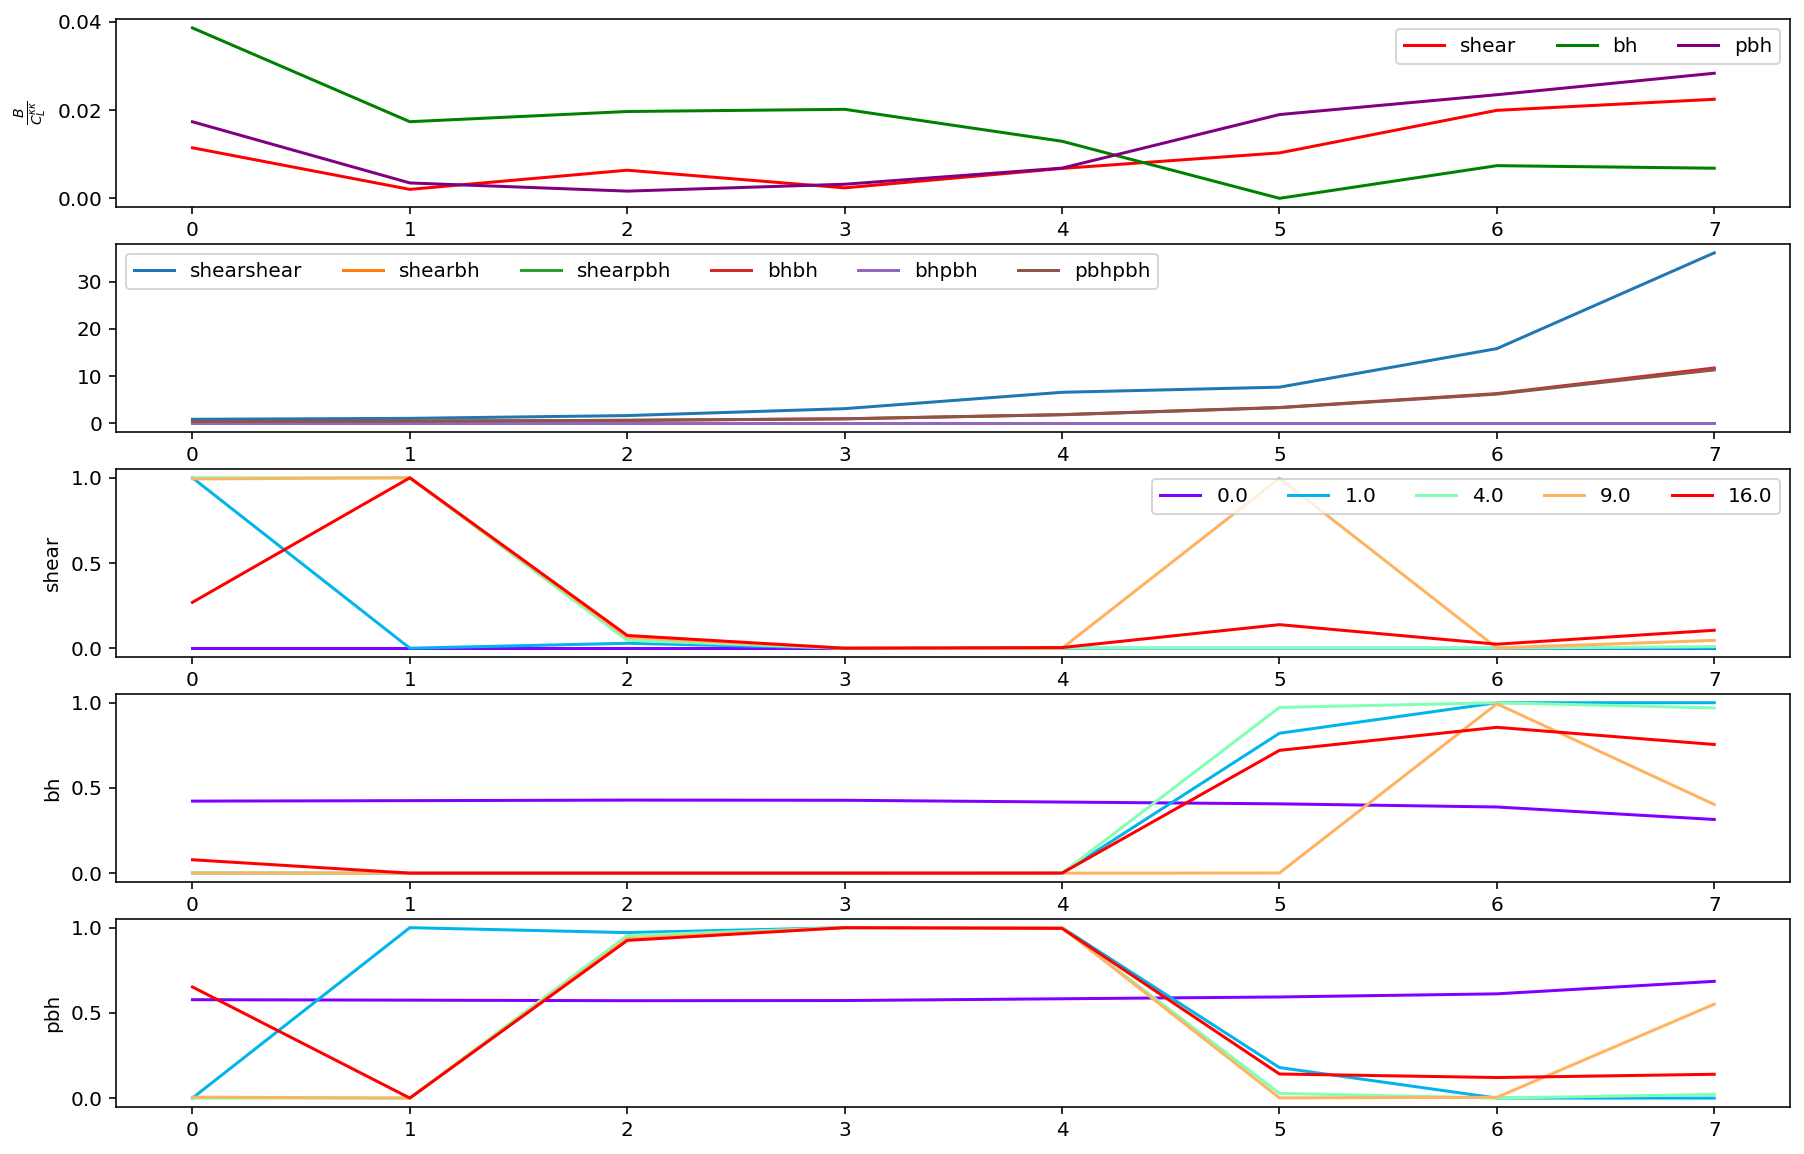

In [77]:
fig, axs = plt.subplots(nrows = 2+len(estimators), figsize = (15, 10))



names_W = list(names)+['$W_L$']
colors = []

for e in estimators:
    colors += [estimators_dictionary[e]['color']]


lmax_directory = direc
resultspath = pathlib.Path(results_directory)
kk, theta, ells, biases, noises, w, x = get_info(lmax_directory, resultspath, fb = 0.)
Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises)

bottom = 2

for k in range(Optimizerkk.Ne):
        ff = lambda x: abs(x)
        axs[0].plot(ff(Optimizerkk.biases_selected[k, k]/Optimizerkk.theory_selected), label = names_W[k], color = colors[k])

axs[0].legend(ncol = Optimizerkk.Ne)
axs[0].set_ylabel('$\\frac{B}{C_L^{\\kappa\\kappa}}$')


for k in range(Optimizerkk.Ne):
    for j in range(k, Optimizerkk.Ne):
        ff = lambda x: abs(x)
        axs[1].plot(ff(Optimizerkk.noises_selected[k, j]/Optimizerkk.theory_selected), label = names_W[k]+names_W[j])
        
axs[1].legend(ncol = 6)

for k in range(Optimizerkk.Ne):
    resultkk = best.Res()
    for ii, fb in enumerate(fbs):
        #d = make_table(resultspath, all_lmaxes_directories, ['BH', 'SYBH', 'PH', 'SY'], fb = fb, include_estimators = False)
        #direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
        if fb == 0. and k == 0:
            print(fb, direc)

        resultkk.load_all(resultspath/lmax_directory, f'auto_fb_{fb}')
        weights = resultkk.ws[:, k]
        weights[weights<1e-5] = 0.
        #print(d.sort_values(by = 'Total Auto').head(1))
        label = fb if k == 0 else None
        axs[k+bottom].plot(weights, color = colors_plotting[ii], label = label)
    axs[k+bottom].set_ylabel(names_W[k])
    axs[0+bottom].legend(ncol = len(fbs))
    
plt.show()

## Looking for best config

In [118]:
invvariance = False
if invvariance:
    inv_variance_dir = 'inversevariance'
else:
    inv_variance_dir = ''
    

In [297]:
fbs = np.array([0., 1., 4., 9., 16.])

plotsout = pathlib.Path('plots26042021')

In [505]:
nocross = False
crosstag = '_nocross' if nocross else ''

optim = True
optimtag = '_ofoptim' if optim else ''

if (nocross and optim):
    precisetitle = 'no cross, with filt abs'
elif (nocross and not optim):
    precisetitle = 'no cross'
elif (not nocross and optim):
    precisetitle = 'with cross, with filt abs'
elif (not nocross and not optim):
    precisetitle = 'with cross'

In [506]:
dd = {}
dd['Name'] = 'HUOK3500'
dd['Total Auto'] = all_ref[0]
dd['Noise Auto'] = all_ref[1]
dd['Bias Auto'] = all_ref[2]

In [494]:
e = np.ones(3)

array([7.81615547e-08, 8.07981067e-08, 8.74326286e-08, 1.01668272e-07,
       1.26297807e-07, 1.38723484e-07, 1.37033669e-07, 1.30848920e-07])

In [503]:
kk, theta, ells, biases, noises, w, x = get_info('s3000b3000p3500', resultspath, fb = fb)
Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)

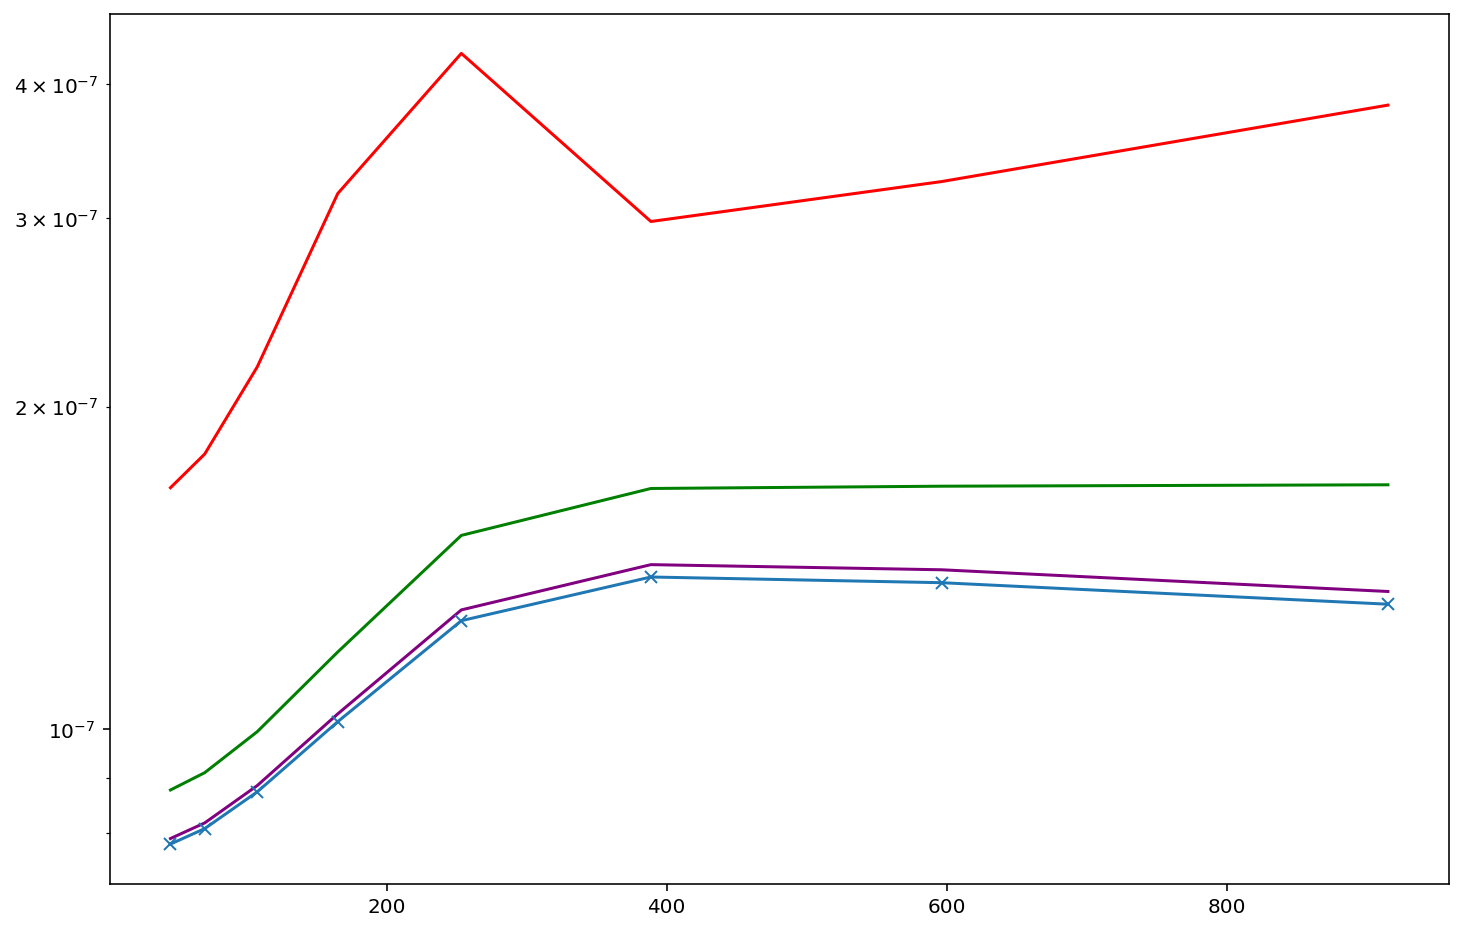

In [504]:
plt.plot(Optimizerkk.ells_selected, Optimizerkk.noises_selected[0, 0], color = 'red')
plt.plot(Optimizerkk.ells_selected, Optimizerkk.noises_selected[1, 1], color = 'green')
plt.plot(Optimizerkk.ells_selected, Optimizerkk.noises_selected[2, 2], color = 'purple')
plt.plot(Optimizerkk.ells_selected, Optimizerkk.noises_selected[1, 2], marker = 'x')
plt.yscale('log')

               Name  Total Auto  Noise Auto  Bias Auto
51  s3000b4500p3000    0.000048    0.006941   0.037069
27  s3500b4500p3000    0.000048    0.006941   0.037069
50  s4000b4500p3000    0.000048    0.006941   0.037069
53  s3000b4500p4000    0.000048    0.006941   0.037069
60  s3000b4500p3500    0.000048    0.006941   0.037069
    Bias Auto  Noise Auto rtr  Bias Auto rtr
51   0.037069        1.011825       1.311464
27   0.037069        1.011825       1.311464
50   0.037069        1.011825       1.311464
53   0.037069        1.011825       1.311464
60   0.037069        1.011825       1.311464
s3000b4500p3000
0.0069406619750703655 0.00694066197474203


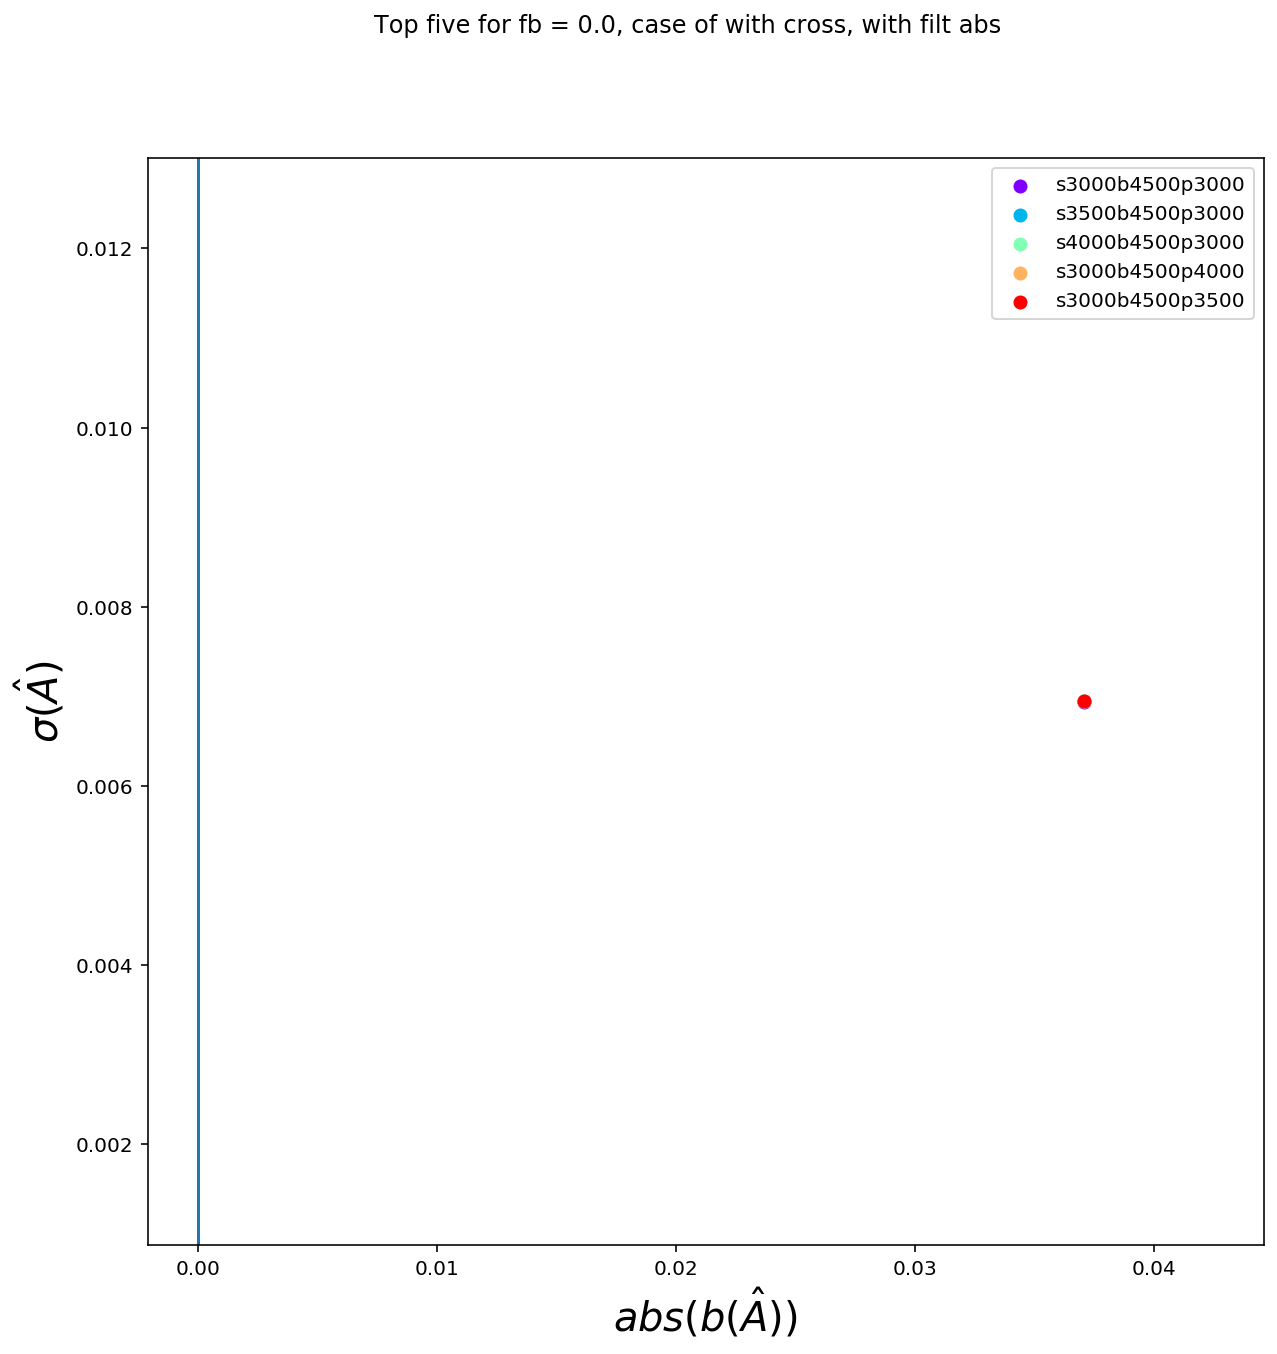

               Name  Total Auto  Noise Auto  Bias Auto
35  s3000b3500p3500    0.000099    0.008100   0.005818
19  s4500b3500p3500    0.000101    0.008077   0.005951
8   s4000b3500p3500    0.000101    0.008077   0.005951
26  s3500b3500p3500    0.000101    0.008077   0.005951
24  s3000b4000p3500    0.000101    0.008120   0.005904
    Bias Auto  Noise Auto rtr  Bias Auto rtr
35   0.005818        1.180794       0.205845
19   0.005951        1.177533       0.210542
8    0.005951        1.177533       0.210542
26   0.005951        1.177533       0.210542
24   0.005904        1.183807       0.208864
s3000b3500p3500
0.008099716905630312 0.007494022039260606


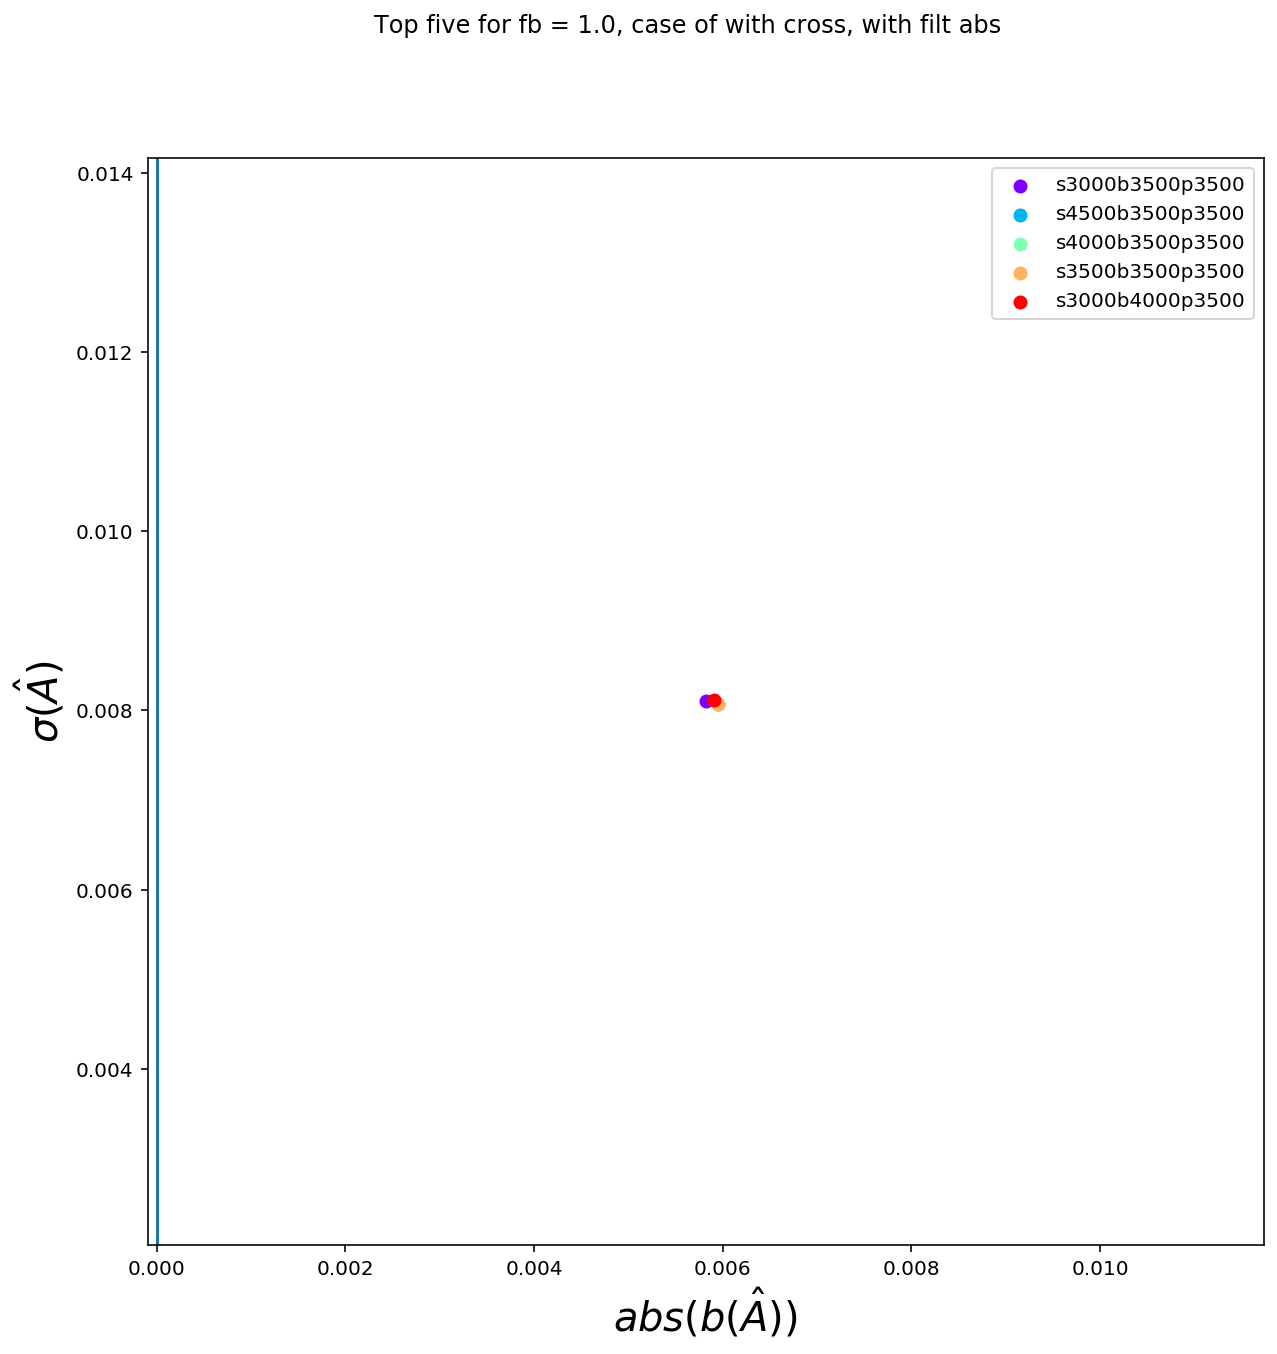

               Name  Total Auto  Noise Auto  Bias Auto
35  s3000b3500p3500    0.000192    0.008747   0.005366
13  s3000b3000p3500    0.000194    0.008925   0.005353
24  s3000b4000p3500    0.000194    0.008907   0.005361
60  s3000b4500p3500    0.000195    0.008943   0.005353
8   s4000b3500p3500    0.000199    0.008796   0.005512
    Bias Auto  Noise Auto rtr  Bias Auto rtr
35   0.005366        1.275210       0.189853
13   0.005353        1.301060       0.189390
24   0.005361        1.298459       0.189656
60   0.005353        1.303802       0.189368
8    0.005512        1.282264       0.195023
s3000b3500p3500
0.00874736539686481 0.008322108392034682


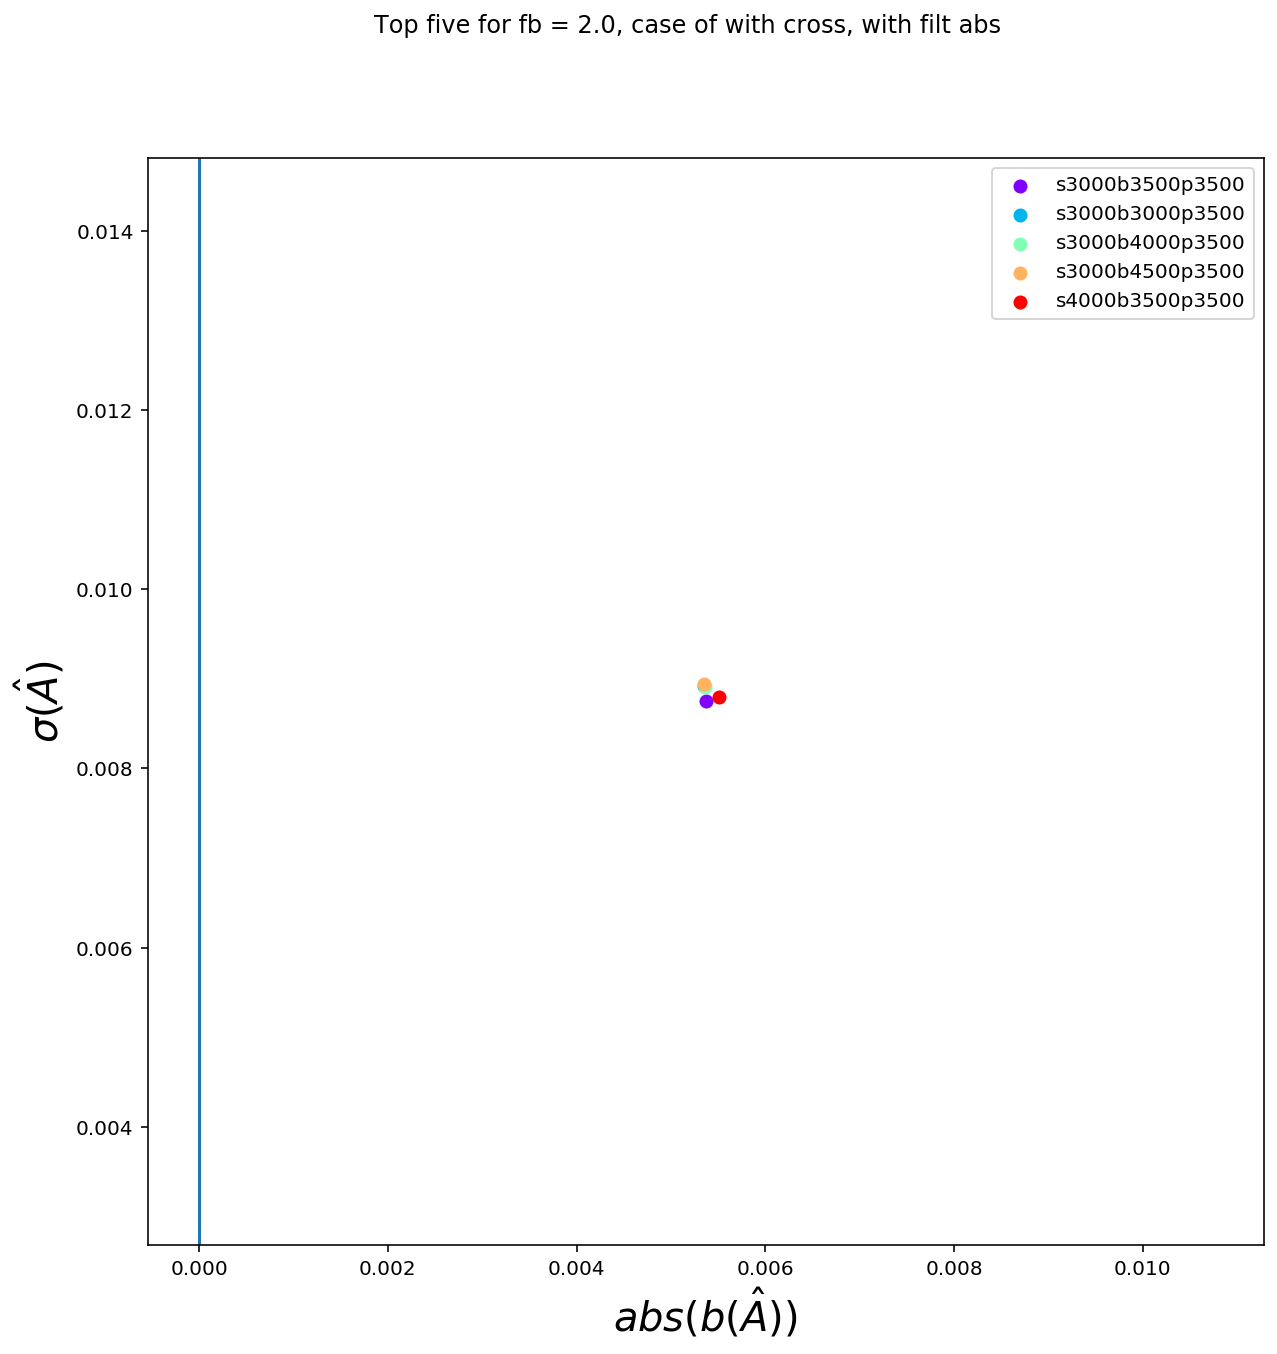

               Name  Total Auto  Noise Auto  Bias Auto
45  s3000b3000p4000    0.000303    0.011759   0.004278
53  s3000b4500p4000    0.000303    0.011760   0.004277
5   s3000b3500p4000    0.000303    0.011760   0.004277
18  s3000b4000p4000    0.000303    0.011760   0.004277
40  s3500b3000p4000    0.000308    0.011958   0.004288
    Bias Auto  Noise Auto rtr  Bias Auto rtr
45   0.004278        1.714210       0.151336
53   0.004277        1.714348       0.151330
5    0.004277        1.714348       0.151330
18   0.004277        1.714348       0.151330
40   0.004288        1.743201       0.151690
s3000b3000p4000
0.011758712629240385 0.011578080581527893


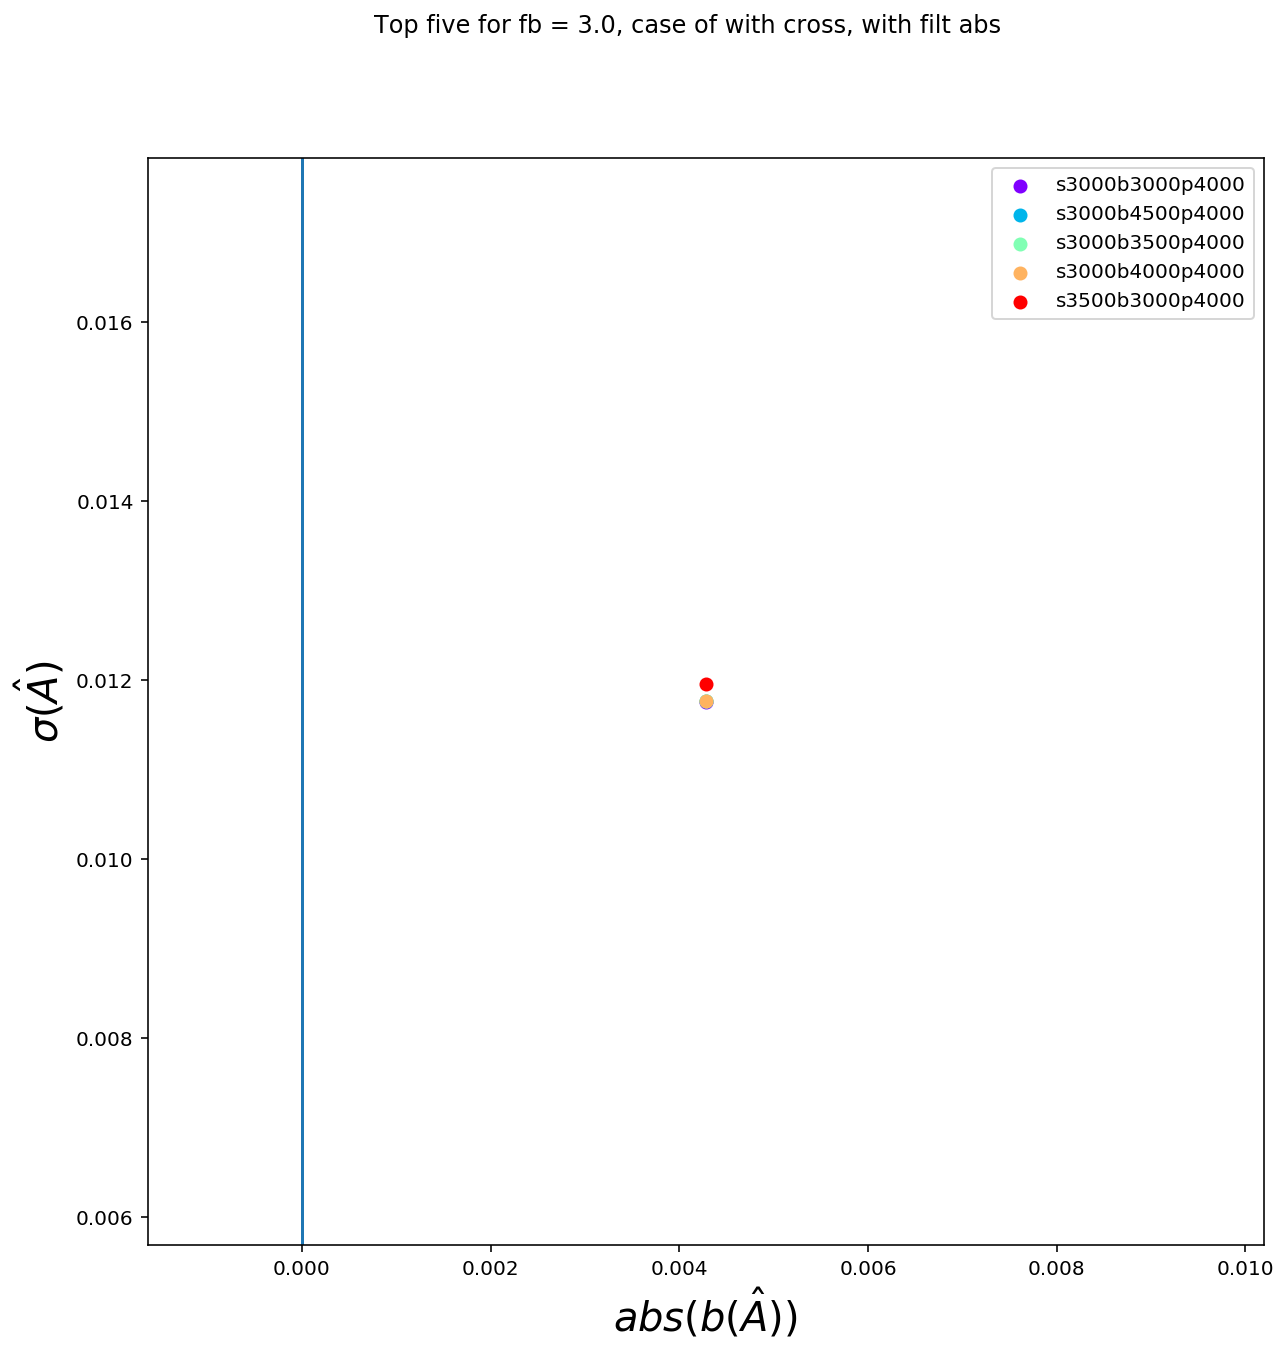

               Name  Total Auto  Noise Auto  Bias Auto
53  s3000b4500p4000    0.000417    0.013479   0.003837
45  s3000b3000p4000    0.000417    0.013479   0.003837
5   s3000b3500p4000    0.000417    0.013479   0.003837
18  s3000b4000p4000    0.000417    0.013479   0.003837
40  s3500b3000p4000    0.000423    0.013771   0.003816
    Bias Auto  Noise Auto rtr  Bias Auto rtr
53   0.003837        1.965011       0.135756
45   0.003837        1.965011       0.135756
5    0.003837        1.965011       0.135756
18   0.003837        1.965011       0.135756
40   0.003816        2.007527       0.135016
s3000b4500p4000
0.013479094149031732 0.013242961717496012


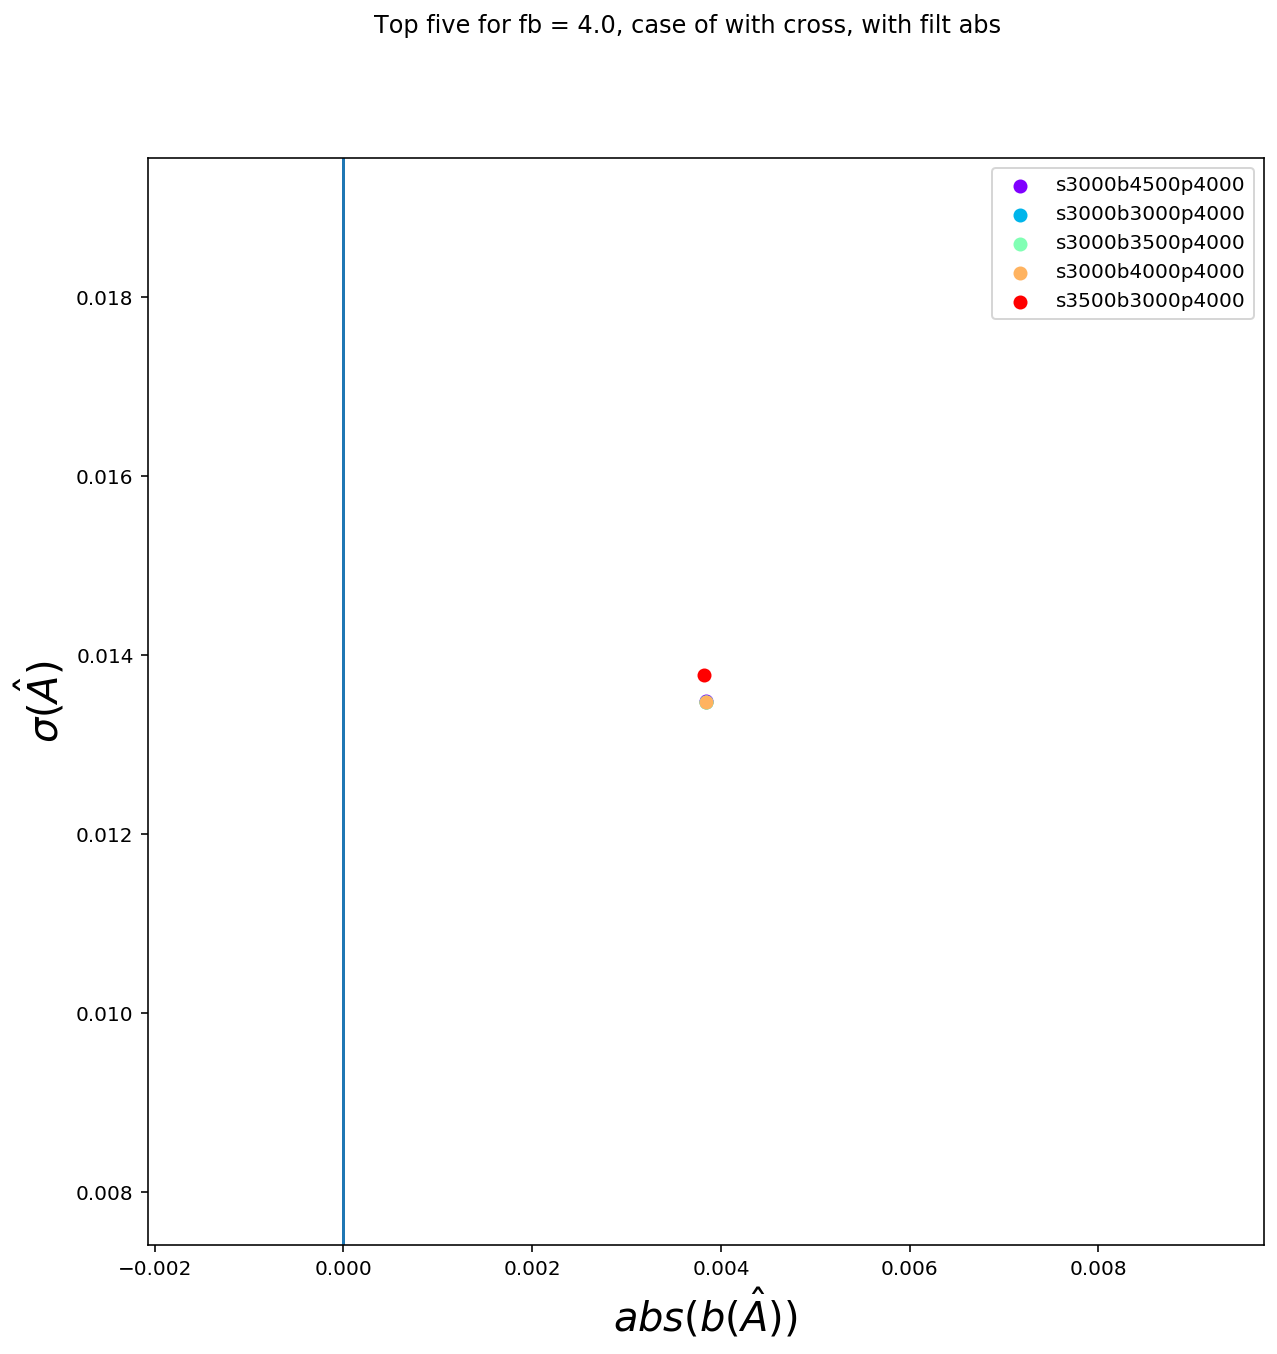

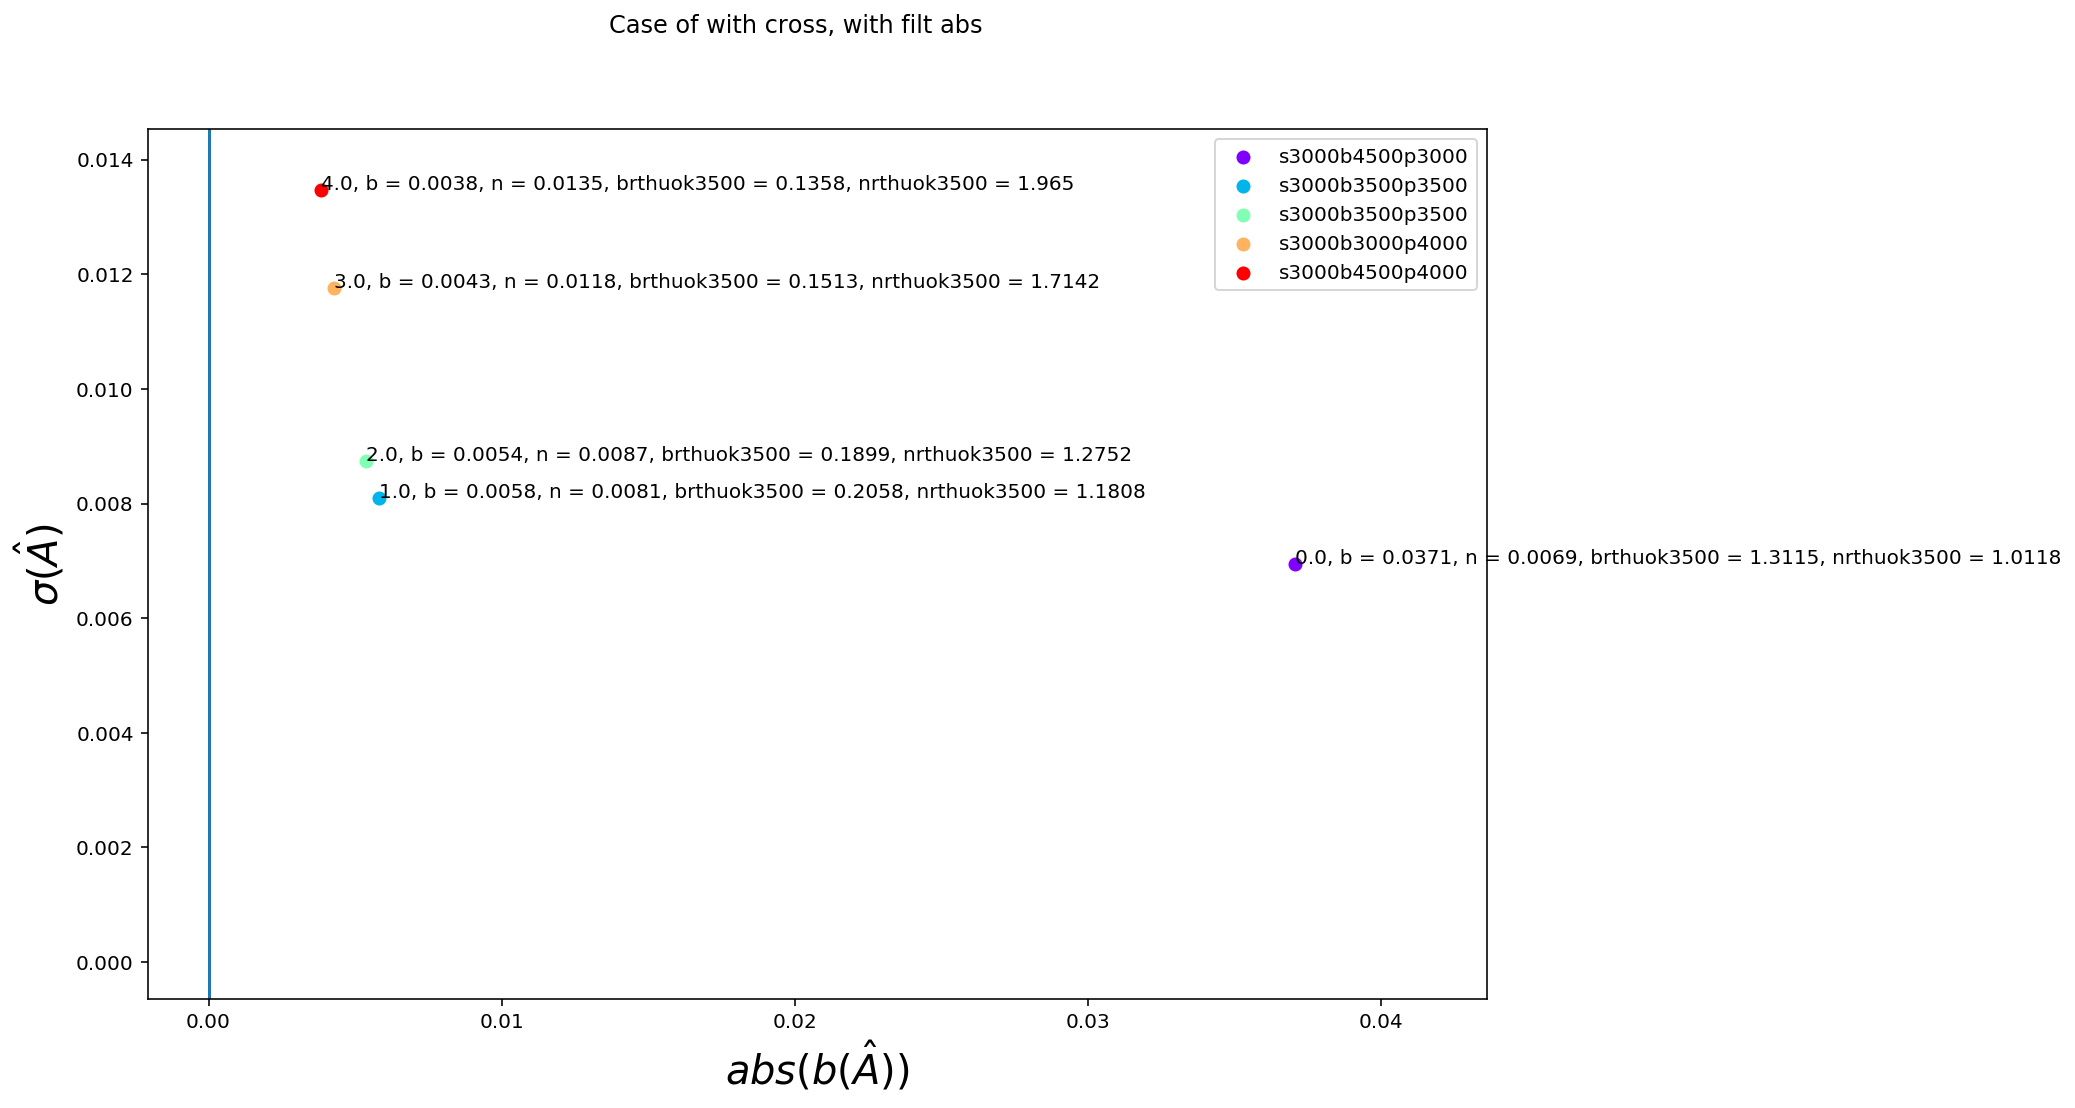

In [507]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

all_best_direcs = []

names_W = list(names)+['$W_L$']
names_W

for ii, fb in enumerate(fbs):
    d = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH'], fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = inv_variance_dir)
    
    dref = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH'], fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                      include_estimators = False, extradir = inv_variance_dir, include_ref = True)

    Ntop = 5
    
    print(d.sort_values(by = 'Total Auto').head(Ntop))
    
    print(dref.sort_values(by = 'Total Auto').head(Ntop).iloc[:5, 3:])

    top5 = list(d.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    
    direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
    print(direc)
    lmax_directory = direc
    
    all_best_direcs += [direc]
    
    kk, theta, ells, biases, noises, w, x = get_info(direc, resultspath, fb = fb)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)
    
    if optim:
        filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
        Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected)              
                  
                  
    resultkk = best.Res()
    f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)
    resultkk.load_all(resultspath/lmax_directory/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
    
    results_array = np.load(resultsdir/direc/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    print(ntemp, n(resultkk.x))
    
    ns = np.append(ns, ntemp)
    bs = np.append(bs, btemp)
    fs = np.append(fs, ftemp)
    
    smallns = []
    smallbs = []
    for temp_lmax_directory in top5:
        results_array = np.load(resultsdir/temp_lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns += [ntemp]
        smallbs += [btemp]
        
    smallbs = np.array(smallbs)
    smallns = np.array(smallns)
        
    fig, ax = plt.subplots(figsize = (10, 10))
    fbname = np.sqrt(fb)
    fig.suptitle(f'Top five for fb = {fbname}, case of {precisetitle}')
    ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
    ax.set_xlabel('$abs(b(\hat{A}))$', size = 20)
    for i, c in enumerate(zip(abs(smallbs), smallns)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5[i])
    ax.legend()
    ax.axvline(0., ymin = 0, ymax = 1)
    fbname = np.sqrt(fb)
    fig.savefig(plotsout/f'top5_for_{fbname}{crosstag}{optimtag}.png', bbox_inches = 'tight', dpi = 300)
    plt.show()  

    
    
fig, ax = plt.subplots()
fig.suptitle(f'Case of {precisetitle}')
ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
ax.set_xlabel('$abs(b(\hat{A}))$', size = 20)
for i, c in enumerate(zip(abs(bs), ns)):
    b, n = c
    ax.scatter(b, n, color = colors_plotting[i], label = all_best_direcs[i])
    fbname = np.sqrt(fbs[i])
    ax.annotate(f'{fbname}, b = {round(b, 4)}, n = {round(n, 4)}, brthuok3500 = {round(b/b_ref, 4)}, nrthuok3500 = {round(n/n_ref, 4)}', (b, n))
ax.legend()
ax.axvline(0., ymin = 0, ymax = 1)
plt.show()  

In [459]:
relevant_directorties = all_best_direcs
#relevant_directorties = ['b3500sybh3500p4000sy4500']

In [460]:
relevant_directorties

['s3000b4500p3000',
 's4000b3500p3500',
 's3000b3500p3500',
 's3500b3500p3500',
 's3000b3000p3500']

In [461]:
names_W = list(names)+['$W_L$']
names_W

['shear', 'bh', 'pbh', '$W_L$']

In [462]:
colors = ['red', 'green', 'purple', 'yellow']

In [463]:
resultspath

PosixPath('resultssumfg_ILC')

In [464]:
fbs

array([ 0.,  1.,  4.,  9., 16.])

In [465]:
#fbs = np.array([0., 16.])

0.0 s3000b4500p3000


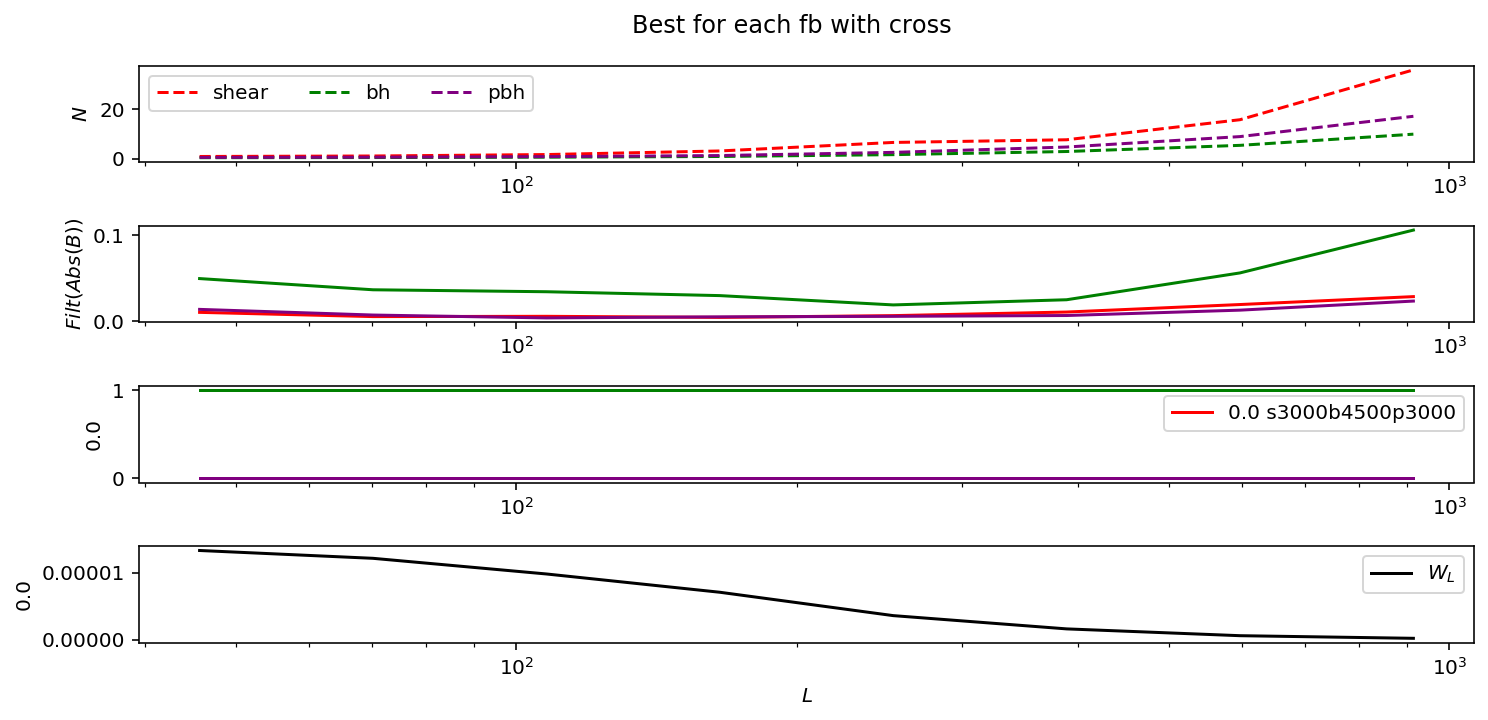

1.0 s4000b3500p3500


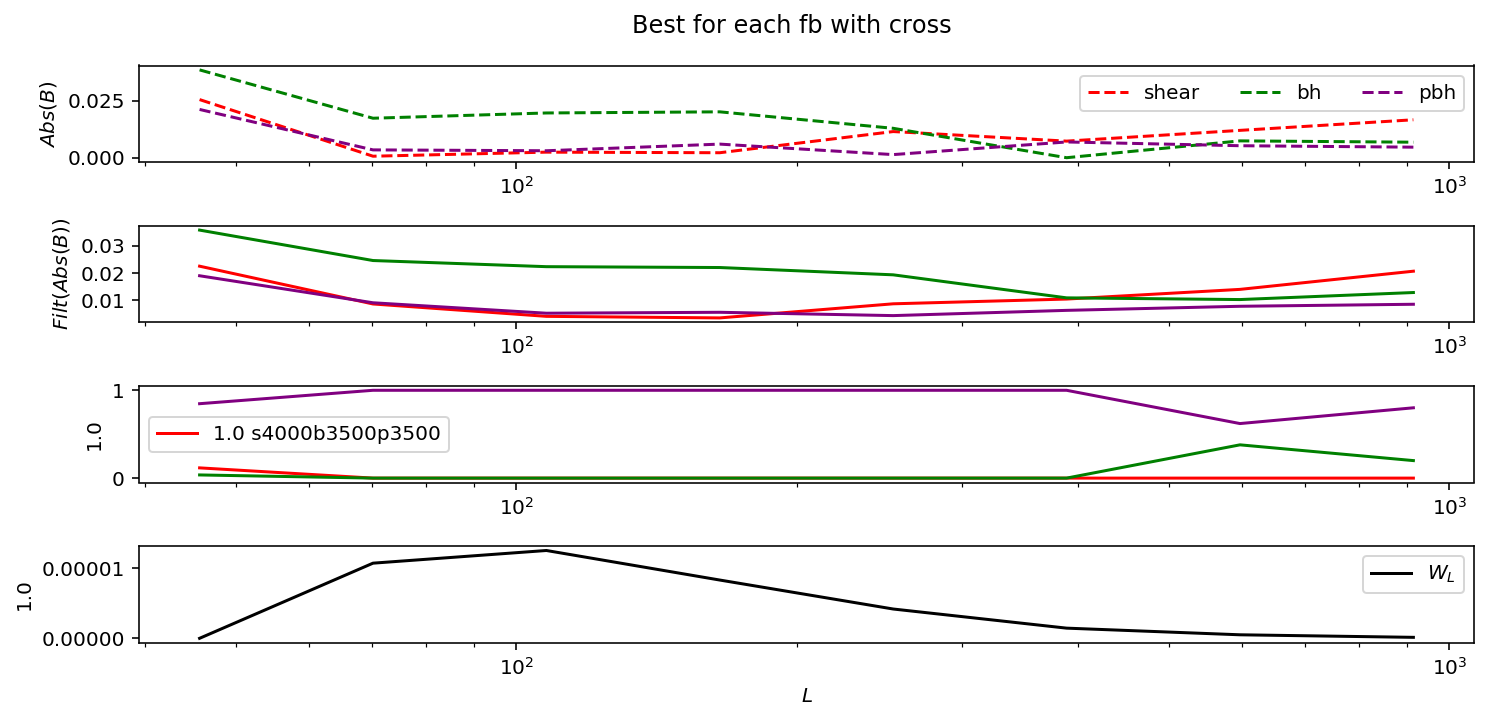

4.0 s3000b3500p3500


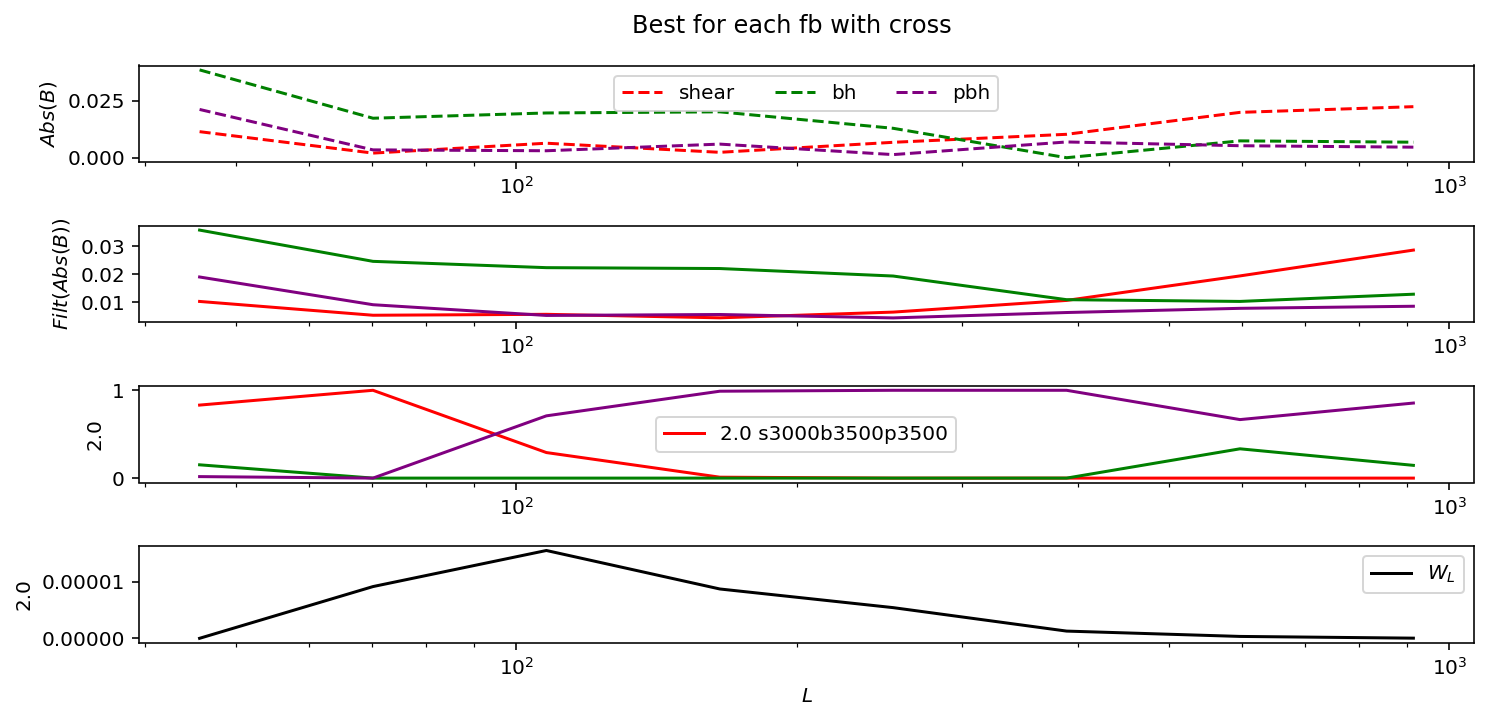

9.0 s3500b3500p3500


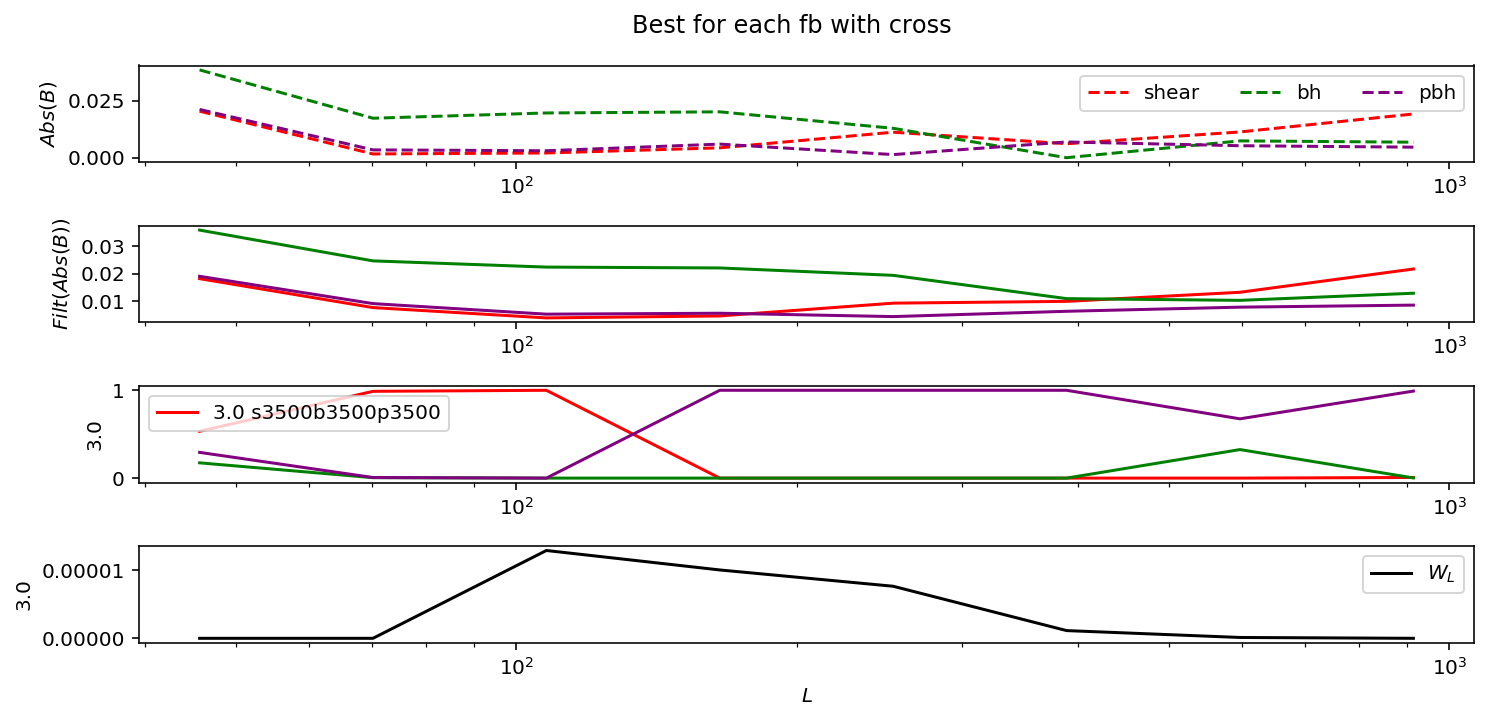

16.0 s3000b3000p3500


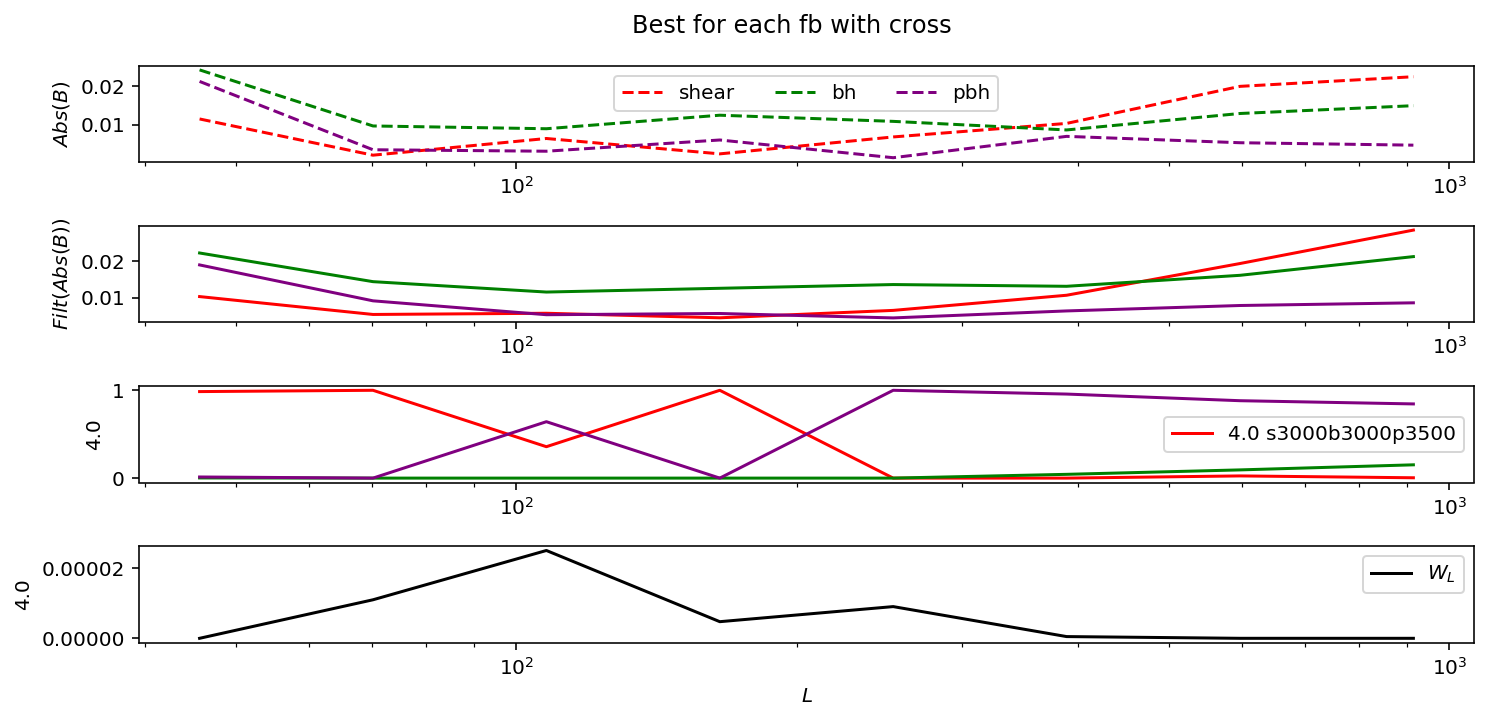

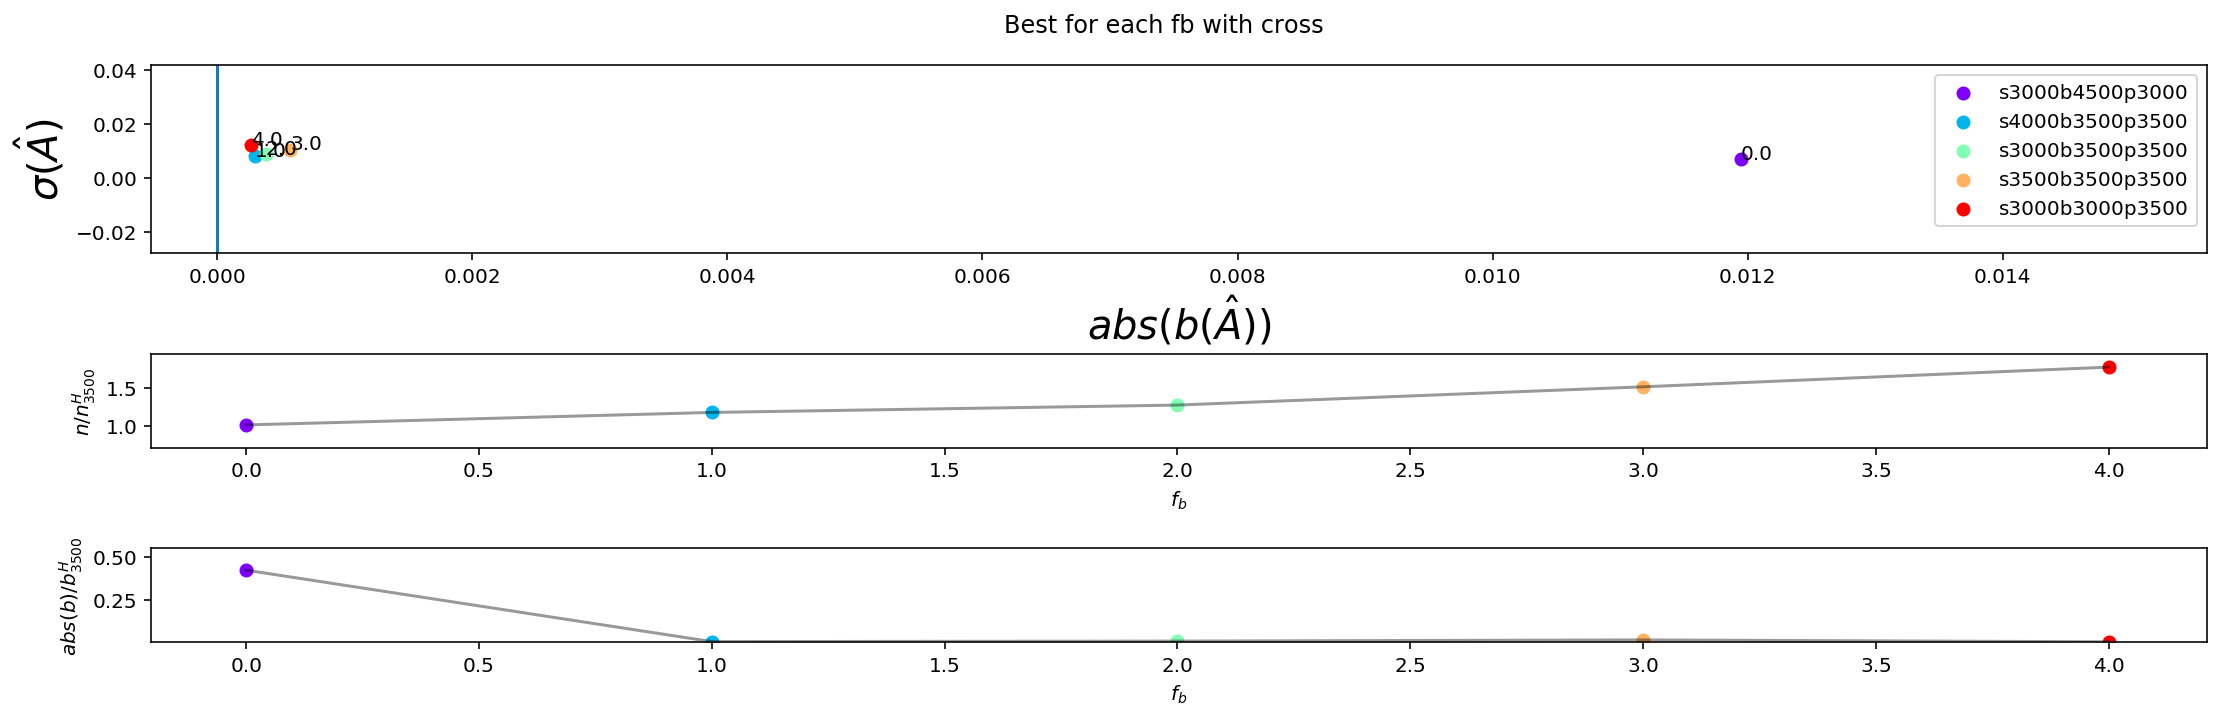

In [475]:
Ndir = len(relevant_directorties)

Nplots = 2
extranumber = 2
extraplots = 3



ns = np.array([])
bs = np.array([])
fs = np.array([])

for i, couple in enumerate(zip(relevant_directorties, fbs)):
    
    fig, axs = plt.subplots(nrows = Nplots+extranumber, figsize = (10, 5))

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    fig.suptitle(f'Best for each fb {precisetitle}')
    #fig.subplots_adjust(hspace = 0.8)

    lmax_directory, fb = couple
    fbname = np.sqrt(fb)
    lmax_directory = pathlib.Path(lmax_directory)
    
    kk, theta, ells, biases, noises, w, x = get_info(lmax_directory, results_directory, fb = fb)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    Ne = Optimizerkk.Ne
    
    for k in range(Optimizerkk.Ne):
        ff = lambda x: abs(x)
        #for j in range(k, Optimizerkk.Ne):
        if fb>0:
            axs[0].plot(Optimizerkk.ells_selected, ff(Optimizerkk.biases_selected[k, k]/Optimizerkk.theory_selected), label = names_W[k], ls = '--', color = colors[k])
        elif fb == 0:
            axs[0].plot(Optimizerkk.ells_selected, ff(Optimizerkk.noises_selected[k, k]/Optimizerkk.theory_selected), label = names_W[k], ls = '--', color = colors[k])
            
        axs[1].plot(Optimizerkk.ells_selected, Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)[k, k]/Optimizerkk.theory_selected, color = colors[k])
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    
    print(fb, lmax_directory)
    
    results_array = np.load(resultsdir/lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    bs = np.append(bs, btemp)
    ns = np.append(ns, ntemp)
    fs = np.append(fs, ftemp)
        
    for k in range(Optimizerkk.Ne):
        resultkk = best.Res()
        #d = make_table(resultspath, all_lmaxes_directories, ['BH', 'SYBH', 'PH', 'SY'], fb = fb, include_estimators = False)
        #direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
        resultkk.load_all(resultspath/lmax_directory, f'auto_fb_{fb}{crosstag}')
        weights = resultkk.ws[:, k]
        weights[weights<1e-5] = 0.
        #print(d.sort_values(by = 'Total Auto').head(1))
        fbname = np.sqrt(fb)
        label = f'{fbname} {lmax_directory}' if k == 0 else None
        axs[0+extranumber].plot(Optimizerkk.ells_selected, weights, color = colors[k], label = label)
        
    axs[0+extranumber].set_ylabel(fbname)
    axs[0+extranumber].legend(ncol = 2, loc = 'best')
    
    axs[0+extranumber].set_xscale('log')
    
    wl = resultkk.ws[:, -1]
    axs[1+extranumber].plot(Optimizerkk.ells_selected, wl, color = 'black', label = '$W_L$')
    axs[1+extranumber].legend(ncol = 1, loc = 'best')
    axs[1+extranumber].set_ylabel(fbname)
    
    axs[1+extranumber].set_xlabel('$L$')    
    axs[1+extranumber].set_xscale('log')

    if fb > 0:
        axs[0].set_ylabel('$Abs(B)$')
    elif fb == 0.:
        axs[0].set_ylabel('$N$')
        
    axs[0].legend(ncol = Ne)
    axs[1].set_ylabel('$Filt(Abs(B))$')
    fbname = np.sqrt(fb)
    fig.savefig(plotsout/f'case_{fbname}{crosstag}{optimtag}.png', bbox_inches = 'tight', dpi = 300)
    
    plt.show()


fig, axs = plt.subplots(nrows = extraplots, figsize = (15, 5), gridspec_kw = {'height_ratios': [2, 1, 1]})

fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.suptitle(f'Best for each fb {precisetitle}')
fig.subplots_adjust(hspace = 0.8)

axs[0].set_ylabel('$\\sigma(\hat{A})$', size = 20)
axs[0].set_xlabel('$abs(b(\hat{A}))$', size = 20)
for i, c in enumerate(zip(abs(bs), ns)):
    b, n = c
    axs[0].scatter(b, n, color = colors_plotting[i], label = all_best_direcs[i])
    fbname = np.sqrt(fbs[i])
    axs[0].annotate(fbname, (b, n))
axs[0].legend()
axs[0].axvline(0., ymin = 0, ymax = 1)


nhuok = all_ref[1]
bhuok = all_ref[2]

y = ns/nhuok
for i, fb in enumerate(fbs):
    axs[1].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i])
axs[1].set_ylim(y[0]*(0.7), y[-1]*(1.1))
axs[1].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
axs[1].set_ylabel(f'$n/n^H_{{{lref_}}}$')
axs[1].set_xlabel('$f_b$')

y = abs(bs)/abs(bhuok)
for i, fb in enumerate(fbs):
    axs[2].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i])
axs[2].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
axs[2].set_ylim(min(y)*(0.7), max(y)*(1.3))
axs[2].set_ylabel(f'$abs(b)/b^H_{{{lref_}}}$')
axs[2].set_xlabel('$f_b$')

fig.savefig(plotsout/f'case_all{crosstag}{optimtag}.png', bbox_inches = 'tight', dpi = 300)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


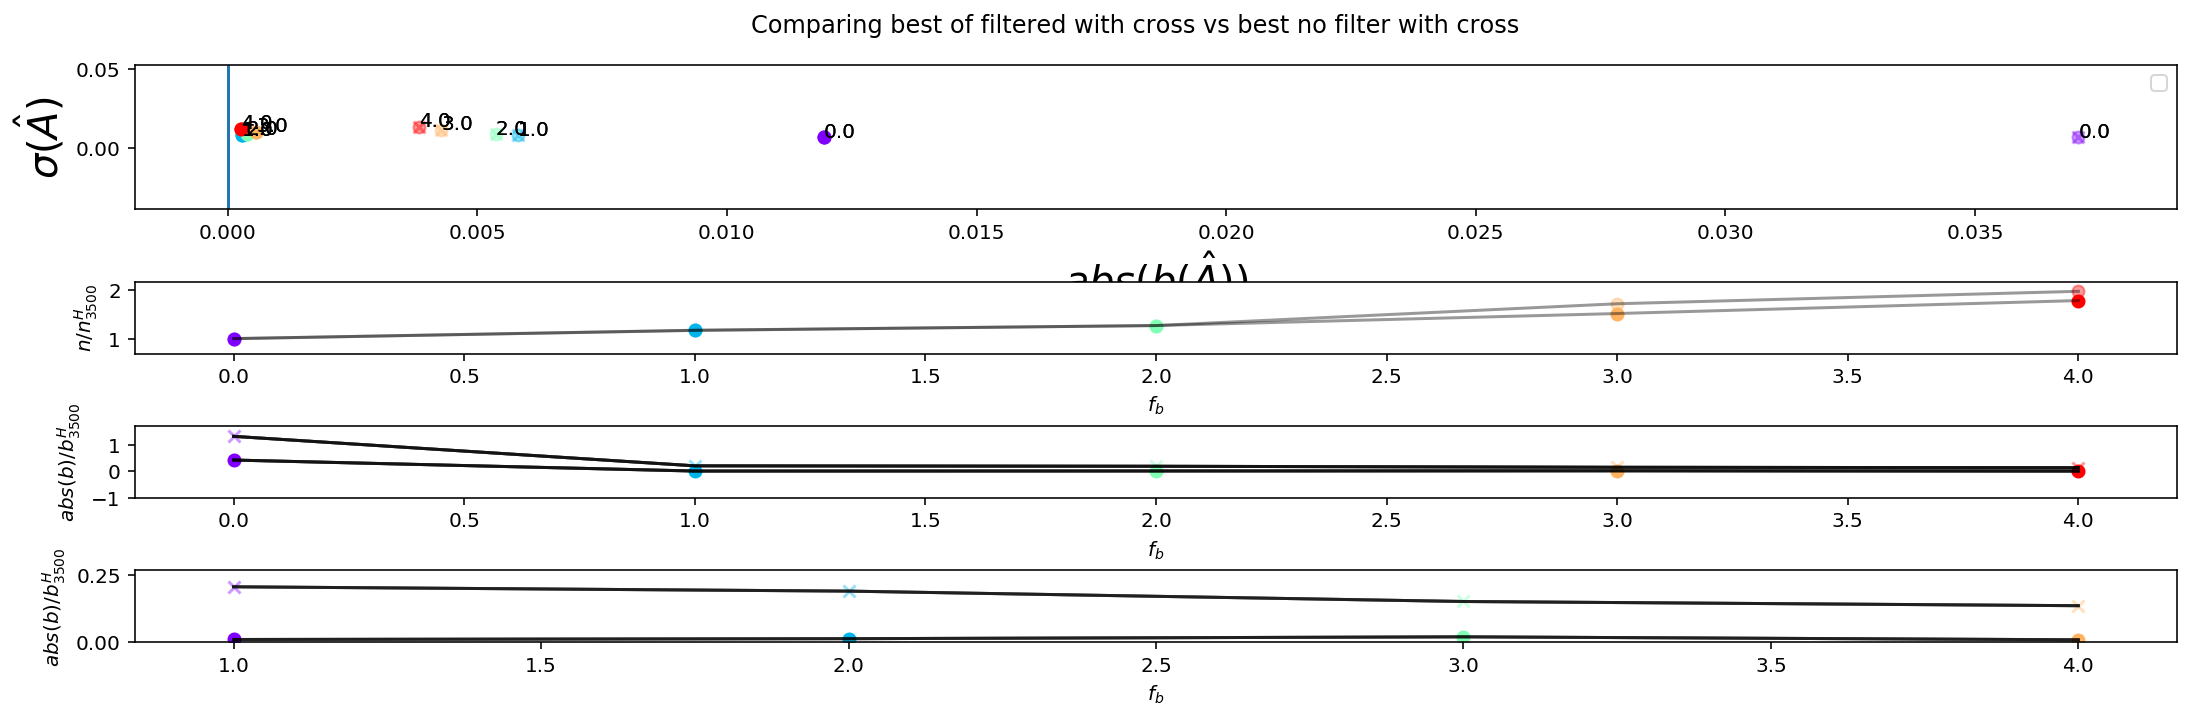

In [427]:
tagshere = ['', '_ofoptim']


fig, axs = plt.subplots(nrows = extraplots+1, figsize = (15, 5), gridspec_kw = {'height_ratios': [2, 1, 1, 1]})

fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.suptitle(f'Comparing best of filtered with cross vs best no filter with cross')
fig.subplots_adjust(hspace = 0.8)

for tag in tagshere:
    
    all_best_direcs = []
    
    ns = np.array([])
    bs = np.array([])
    fs = np.array([])
    
    for ii, fb in enumerate(fbs):
        d = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH'], fb = fb, crosstag = '', optimtag = tag, include_estimators = False, extradir = inv_variance_dir)

        dref = make_table(resultspath, all_lmaxes_directories, ['S', 'BH', 'PH'], fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                          include_estimators = False, extradir = inv_variance_dir, include_ref = True)



        top5 = list(d.sort_values(by = 'Total Auto').head(5).iloc[:5, 0])

        direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
        lmax_directory = direc

        all_best_direcs += [direc]
    

    relevant_directorties = all_best_direcs

    for i, couple in enumerate(zip(relevant_directorties, fbs)):

        lmax_directory, fb = couple
        results_array = np.load(resultsdir/lmax_directory/f'alens_{fb}{tag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array

        bs = np.append(bs, btemp)
        ns = np.append(ns, ntemp)
        fs = np.append(fs, ftemp)
        
    
    alpha = 1. if tag == '' else 0.4
    marker = 'o' if tag == '' else 'x'
              
    for i, c in enumerate(zip(abs(bs), ns)):
        b, n = c
        axs[0].scatter(b, n, color = colors_plotting[i], alpha = alpha)
        fbname = np.sqrt(fbs[i])
        axs[0].annotate(fbname, (b, n))
        
        
    for i, c in enumerate(zip(abs(bs), ns)):
        b, n = c
        axs[0].scatter(b, n, color = colors_plotting[i], alpha = alpha, marker = marker)#, label = all_best_direcs[i])
        fbname = np.sqrt(fbs[i])
        axs[0].annotate(fbname, (b, n))

    axs[0].legend()
    axs[0].axvline(0., ymin = 0, ymax = 1)


    nhuok = all_ref[1]
    bhuok = all_ref[2]

    y = ns/nhuok
    for i, fb in enumerate(fbs):
        axs[1].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i], alpha = alpha)
    axs[1].set_ylim(y[0]*(0.7), y[-1]*(1.1))
    axs[1].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
    axs[1].set_ylabel(f'$n/n^H_{{{lref_}}}$')
    axs[1].set_xlabel('$f_b$')

    y = abs(bs)/abs(bhuok)
    for i, fb in enumerate(fbs):
        axs[2].scatter(np.sqrt(fbs)[i], y[i], color = colors_plotting[i], alpha = alpha, marker = marker)
        axs[2].plot(np.sqrt(fbs), y, color = 'black', alpha = 0.4)
    axs[2].set_ylim(-1, max(y)*(1.3))
    axs[2].set_ylabel(f'$abs(b)/b^H_{{{lref_}}}$')
    axs[2].set_xlabel('$f_b$')
    
    fsel = fbs>0.
    y = (abs(bs)/abs(bhuok))[fsel]
    for i, fb in enumerate(fbs[fsel]):
        axs[3].scatter(np.sqrt(fbs[fsel])[i], y[i], color = colors_plotting[i], alpha = alpha, marker = marker)
        axs[3].plot(np.sqrt(fbs[fsel]), y, color = 'black', alpha = 0.4)
    axs[3].set_ylim(0., max(y)*(1.3))
    axs[3].set_ylabel(f'$abs(b)/b^H_{{{lref_}}}$')
    axs[3].set_xlabel('$f_b$')

   

axs[0].set_ylabel('$\\sigma(\hat{A})$', size = 20)
axs[0].set_xlabel('$abs(b(\hat{A}))$', size = 20)
  

fig.savefig(plotsout/f'comparison_case_all_opt_with_cross_no_opt_with_cross.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [428]:
np.load(resultsdir/lmax_directory/f'alens_1.0.npy')[:, 0]/bhuok

array([0.00310022, 0.32437932, 0.06679469])

In [430]:
np.load(resultsdir/lmax_directory/f'alens_1.0_ofoptim.npy')[:, 0]/bhuok

array([0.0043779 , 0.32437932, 0.22285625])

In [371]:
ns/nhuok

array([0.62118478, 0.68655857, 0.73241783, 0.80686926, 0.90048022])

In [372]:
(0.00690016-0.00426105)/0.00426105

0.619356731322092

In [373]:
bs/bhuok

array([ 0.3085273 , -0.00992414, -0.00793381, -0.01233043, -0.01979735])

In [473]:
def plotuseful(fb, Opt, result, invvariance, lmax_directory):
    

    result.load_all(resultspath/lmax_directory, f'auto_fb_{fb}{crosstag}')

    a = Opt.get_a(result.x, invvariance)
    
    wl = result.ws[:, -1]

    fig, axs = plt.subplots(nrows = 6, sharex = True)

    fig.suptitle(f'$f_b$ = {fb}')
    
    filtered = Opt.filter_(abs(Opt.biases_selected), sigma = 1.5)
    
    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, filtered, Opt.noises_selected)
    
    f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(result.x), n(result.x), b(result.x)
    
    ff = f
    
    combinedb_abs = Optimizerkk_abs.get_bias_part(a, filtered)
    combinedb_abs = wl*combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected*fb
    
    combinedtheta = wl**2*Optimizerkk_abs.get_variance_part(a, Optimizerkk_abs.theta_selected)/Optimizerkk_abs.theory_selected**2.
    
    
    
    axs[3].plot(Opt.ells_selected, combinedtheta, color = 'gold', label = 'Combined Var')
    axs[3].plot(Opt.ells_selected, combinedb_abs, color = 'silver', label = 'Combined Bias')
    
    for index in range(Opt.Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        variance = True
        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        #print(f'Example is for {Optimizerkk.estimators[index]}')
        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        
        axs[2].plot(Opt.ells_selected, wl_example**2*(theta_example/Optimizerkk_abs.theory_selected**2)+wl_example*combinedb_abs_example, color = colors[index], ls = ':')

    for i in range(Opt.Ne):
        biascurve = abs(Opt.biases_selected[i, i])/Opt.theory_selected
        axs[0].plot(Opt.ells_selected, biascurve, label = estimators[i], color = colors[i])
        thetacurve = Opt.theory_selected**2./Opt.theta_selected[i, i, i, i]
        #for j in range(i, 3):
        #    thetacurve = filtered[i, j]/Optimizerkk.theory_selected
        #    axs[1].plot(Opt.ells_selected, thetacurve)
        axs[1].plot(Opt.ells_selected, Opt.filter_(abs(Opt.biases_selected), sigma = 1.5)[i, i]/Optimizerkk.theory_selected, color = colors[i])

        axs[4].plot(Opt.ells_selected, a[:, i], color = colors[i])

    axs[-1].plot(Opt.ells_selected, wl, color = 'black')
        
    axs[0].legend(ncol = Opt.Ne)
    axs[3].legend(ncol = 2)
    axs[3].set_yscale('log')
    axs[2].set_yscale('log')
    
    axs[1].set_xscale('log')
    #axs[1].set_yscale('log')
    axs[0].set_ylabel('abs B')
    axs[1].set_ylabel('filt abs B')
    axs[4].set_ylabel('W')
    axs[-1].set_ylabel('Wl')
    
    plt.show()
    
    return a, result.x, ff

In [471]:
def modify_est_weights(Opt, index, x, l_index, newvalue):
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    x = x.copy()
    x[index+Nest*l_index] = newvalue
    return x

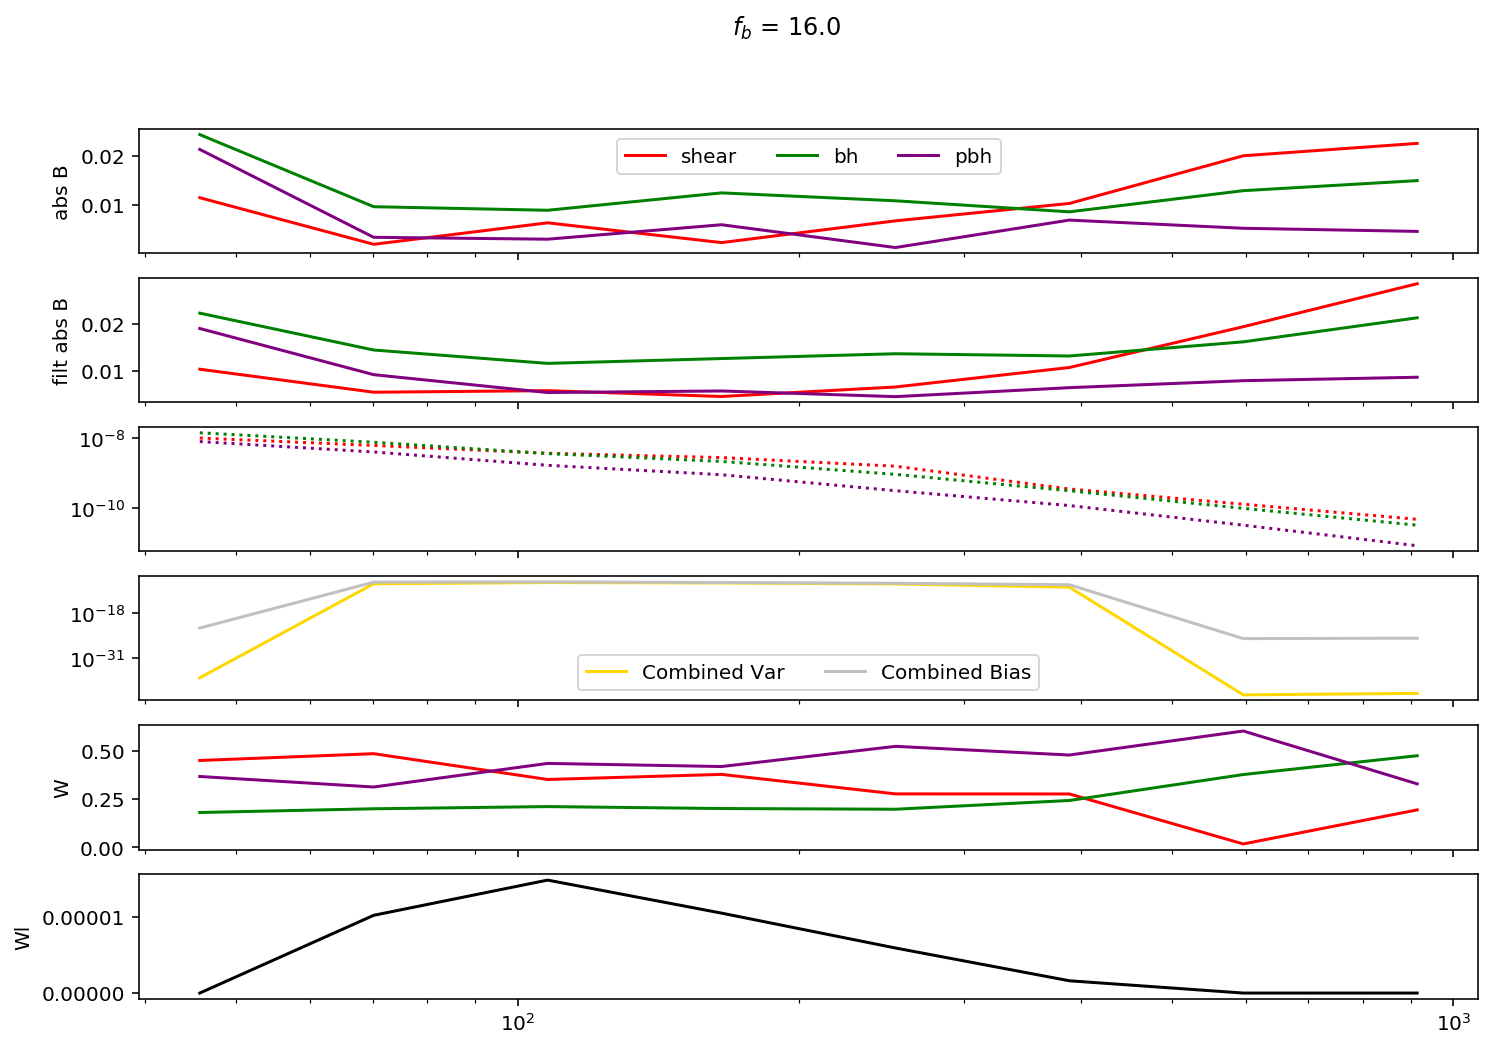

In [472]:
a, xx, ff = plotuseful(16.0, Optimizerkk, resultkk, invvariance, 's3000b3000p3500')

In [399]:
Optimizerkk.ells_selected

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [400]:
a = a.copy()

In [401]:
lselected = Optimizerkk.ells_selected[1]
est1, est2 = 0, 2
l_index = list(Optimizerkk.ells_selected).index(lselected)
newx = modify_est_weights(Optimizerkk, est1, xx, l_index, a[l_index][est2])
newx = modify_est_weights(Optimizerkk, est2, newx, l_index, a[l_index][est1])
aa = Optimizerkk.get_a(newx, invvariance)
aa

array([[6.59473775e-06, 1.69847899e-05, 9.99976420e-01],
       [3.41651977e-07, 1.56751337e-07, 9.99999502e-01],
       [5.35144023e-17, 8.68354596e-17, 1.00000000e+00],
       [3.27256667e-16, 5.77178158e-18, 1.00000000e+00],
       [1.95838001e-17, 4.43823172e-17, 1.00000000e+00],
       [9.99845532e-17, 4.10509630e-15, 1.00000000e+00],
       [6.15998017e-08, 3.22752208e-01, 6.77247730e-01],
       [2.90571130e-08, 1.42135395e-01, 8.57864576e-01]])

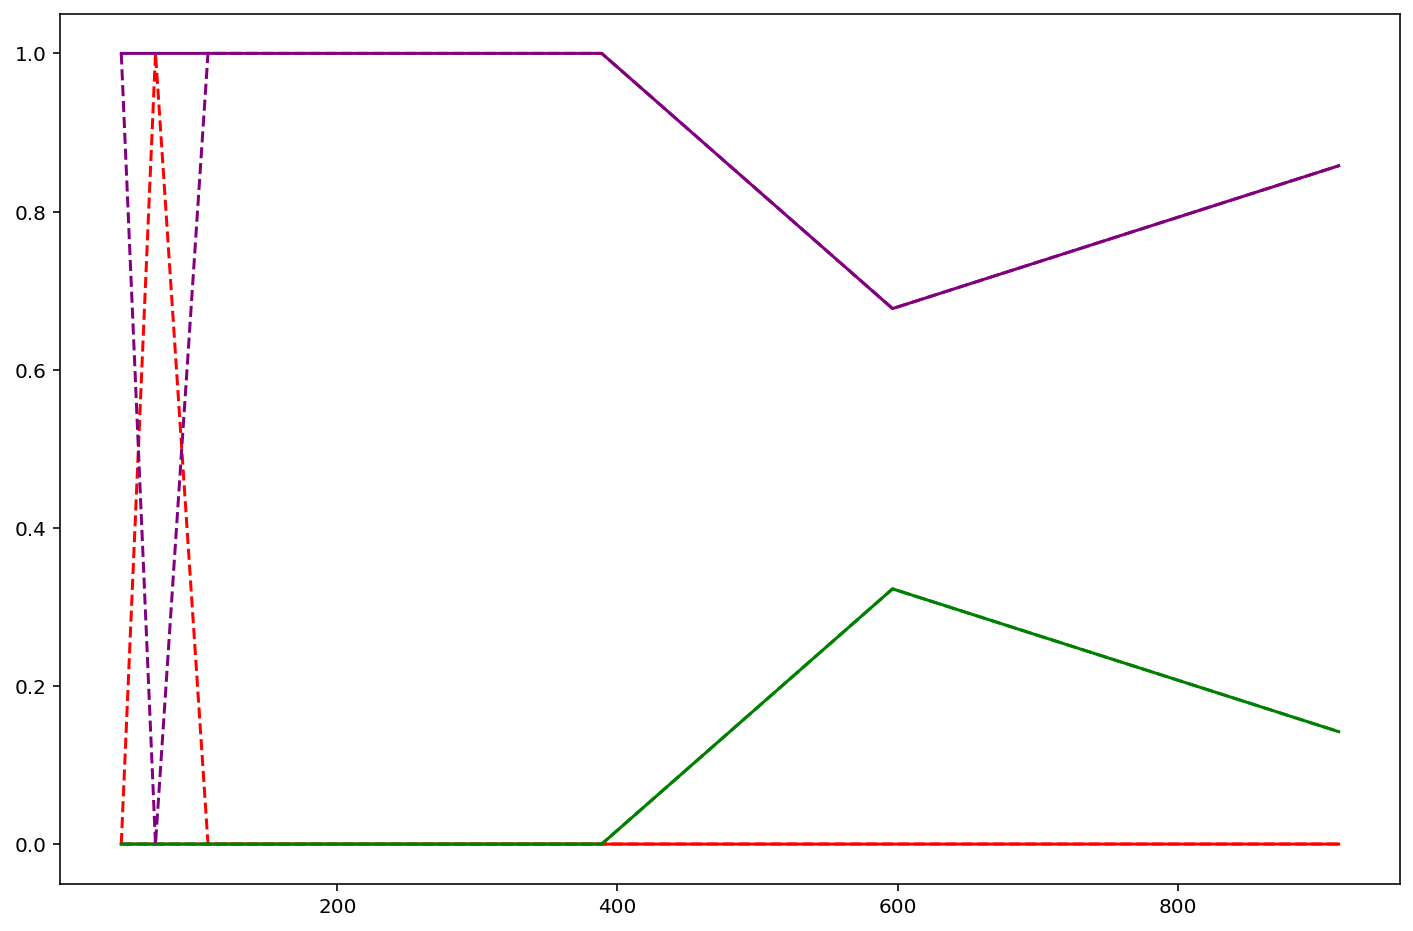

In [402]:
for i in range(Optimizerkk.Ne):
    plt.plot(Optimizerkk.ells_selected, aa[:, i], color = colors[i])
    plt.plot(Optimizerkk.ells_selected, a[:, i], color = colors[i], ls = '--')

In [403]:
xx/newx

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.92695365e+06,
       1.00000000e+00, 3.41652148e-07, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [404]:
ff(xx)/ff(newx)

0.9999999998975991

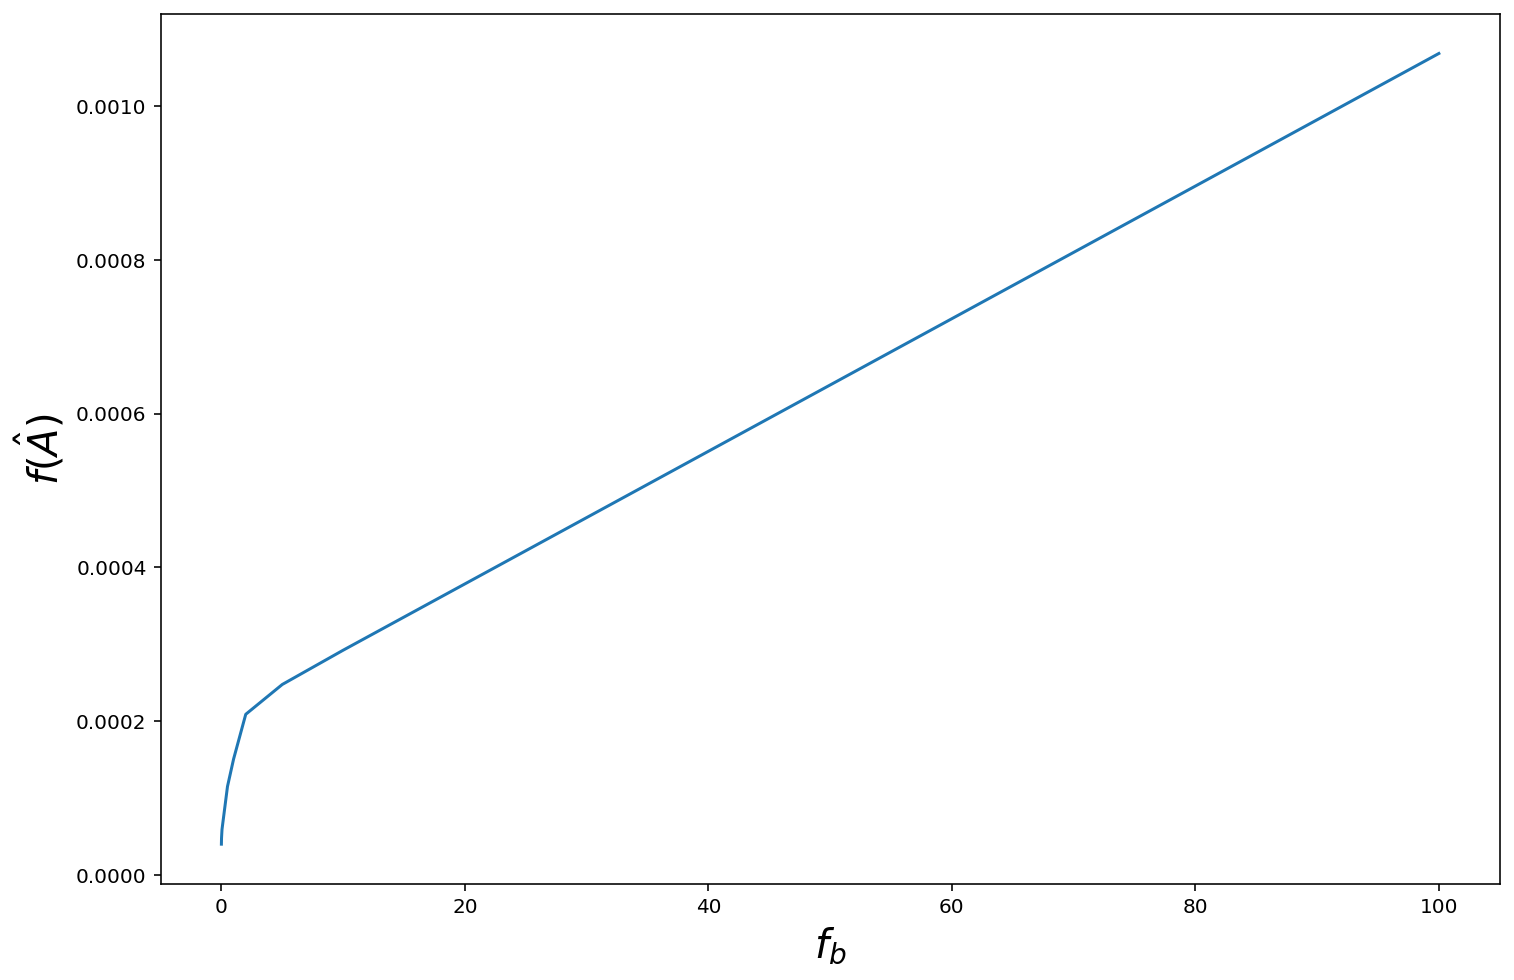

In [118]:
plt.ylabel('$f(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, fs)

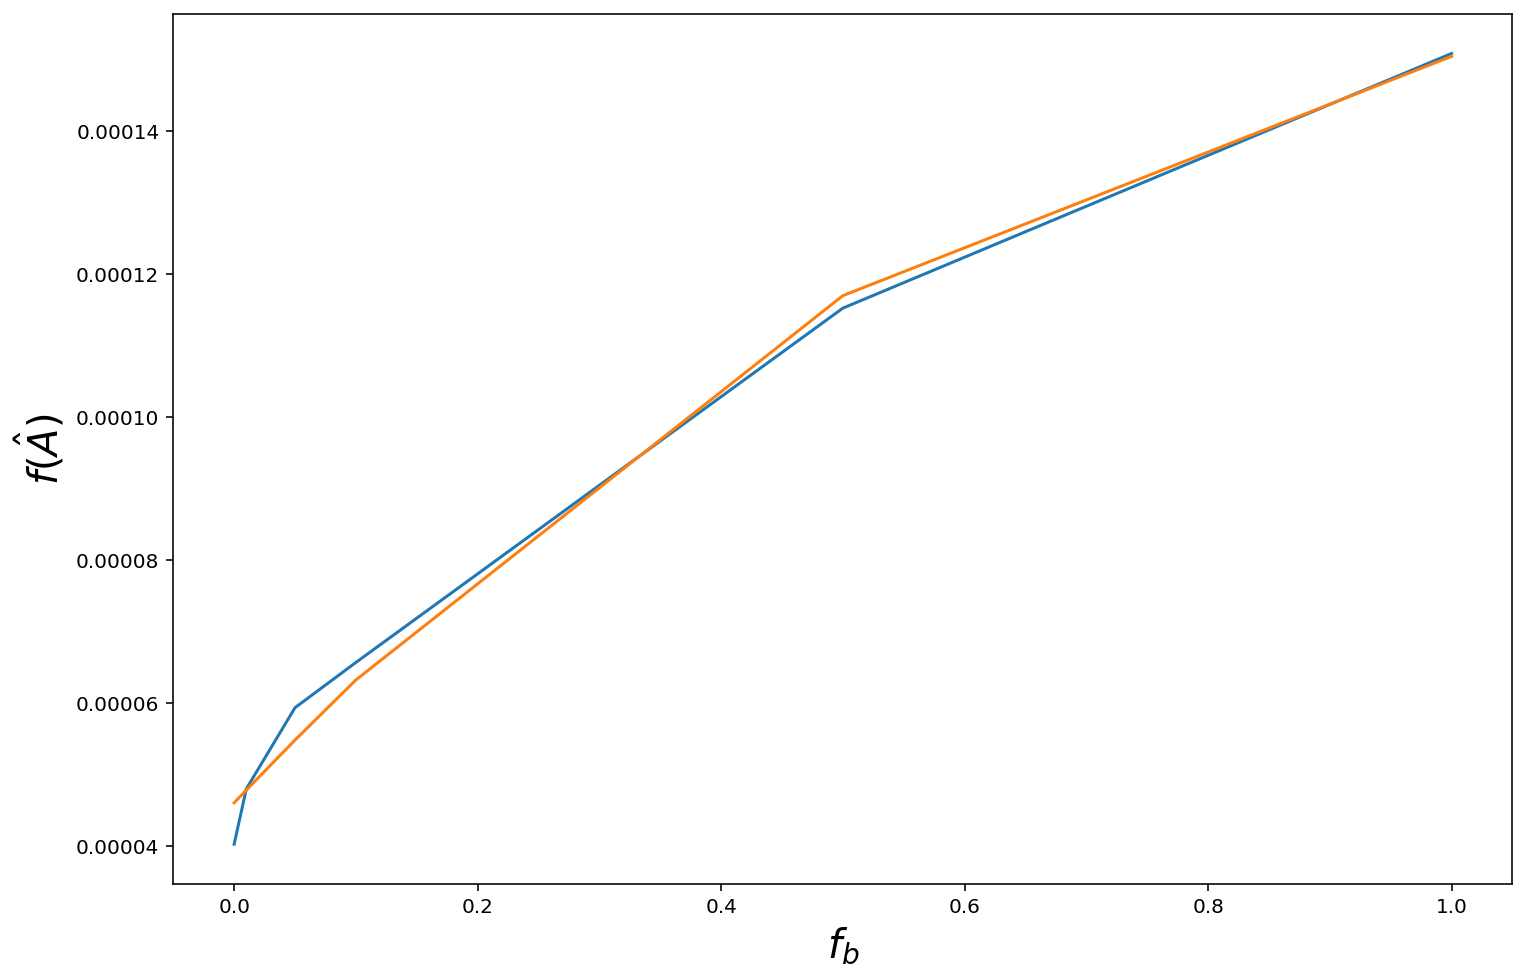

In [153]:
plt.ylabel('$f(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs[fbs<2], fs[fbs<2])

p = np.poly1d(np.polyfit(fbs[fbs<2], fs[fbs<2], 2))
plt.plot(fbs[fbs<2], p(fbs[fbs<2]))

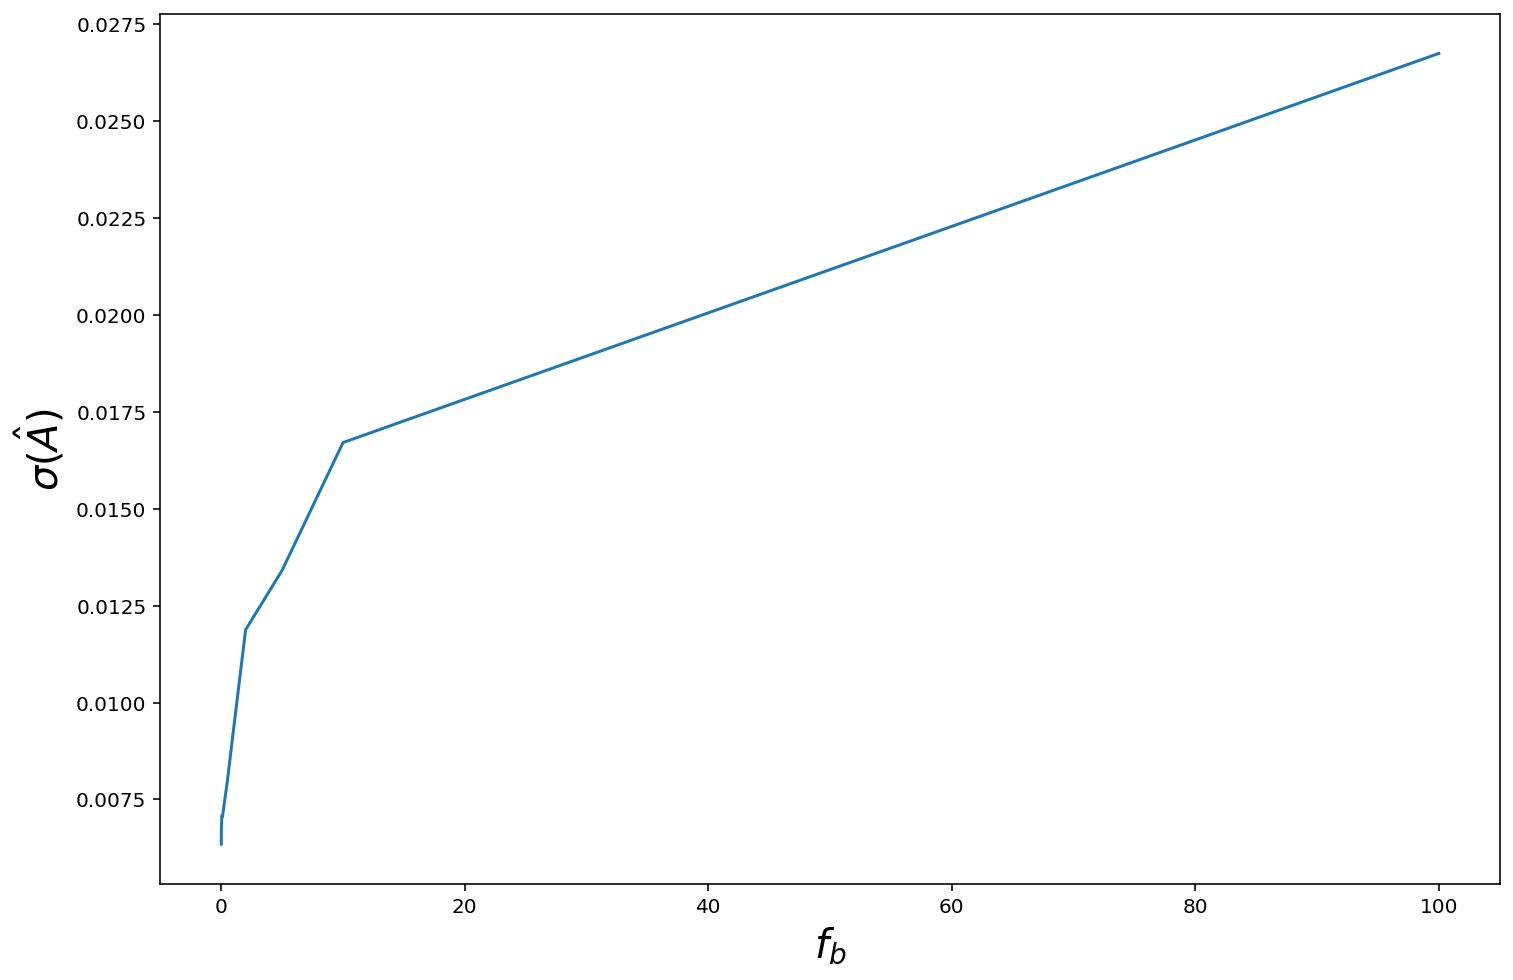

In [119]:
plt.ylabel('$\\sigma(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, ns)

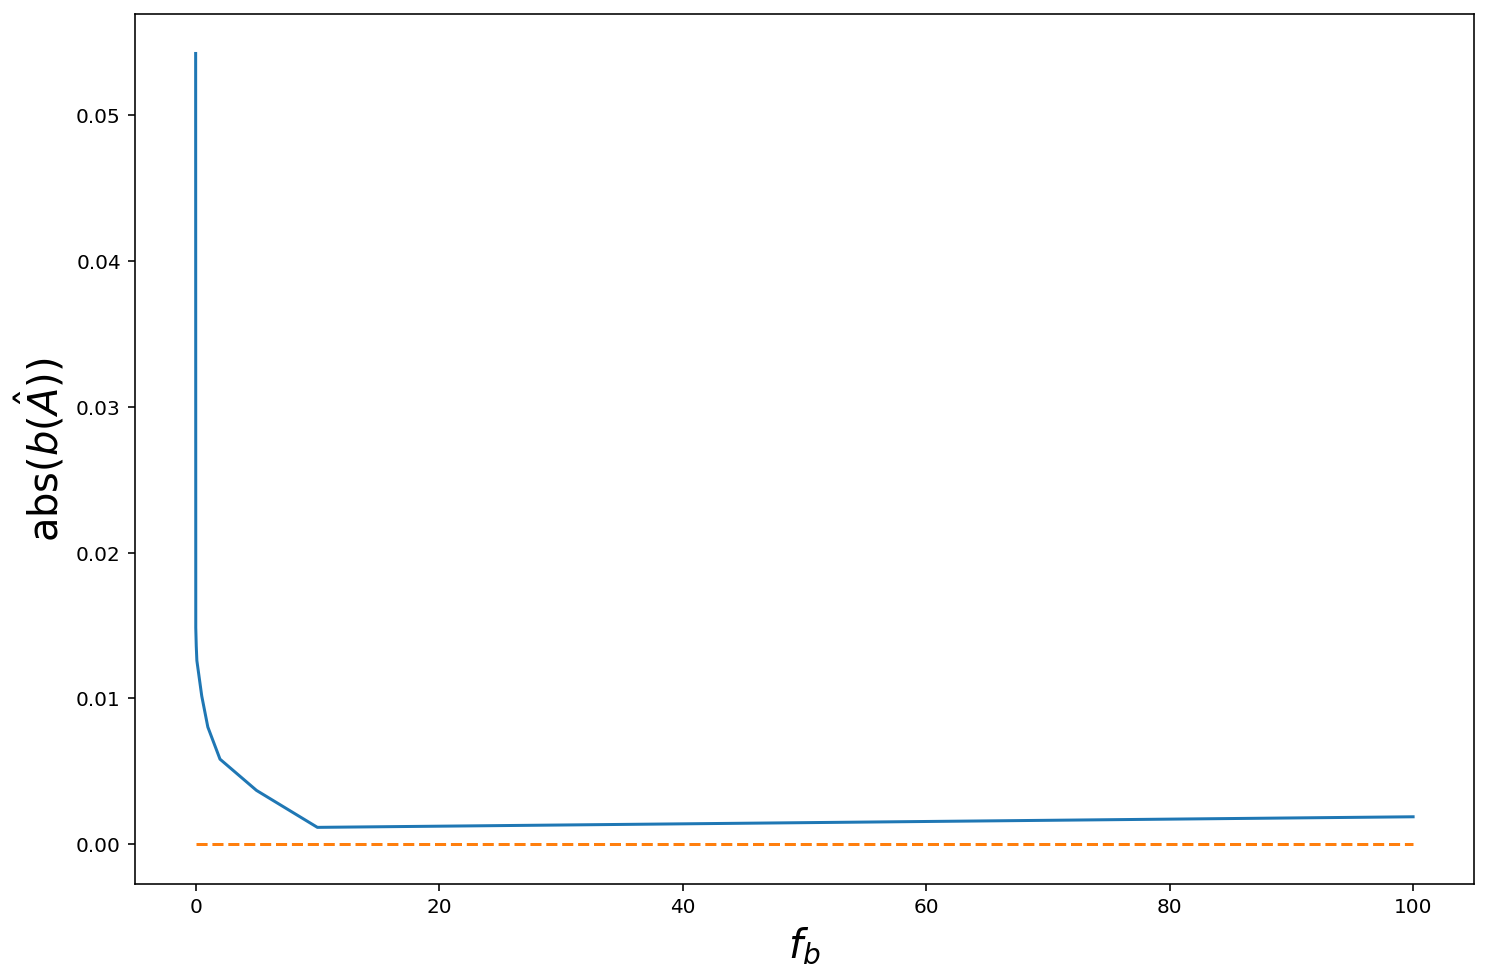

In [125]:
plt.ylabel('abs$(b(\hat{A}))$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, abs(bs))
plt.plot(fbs, np.array(fbs)*0., ls = '--')

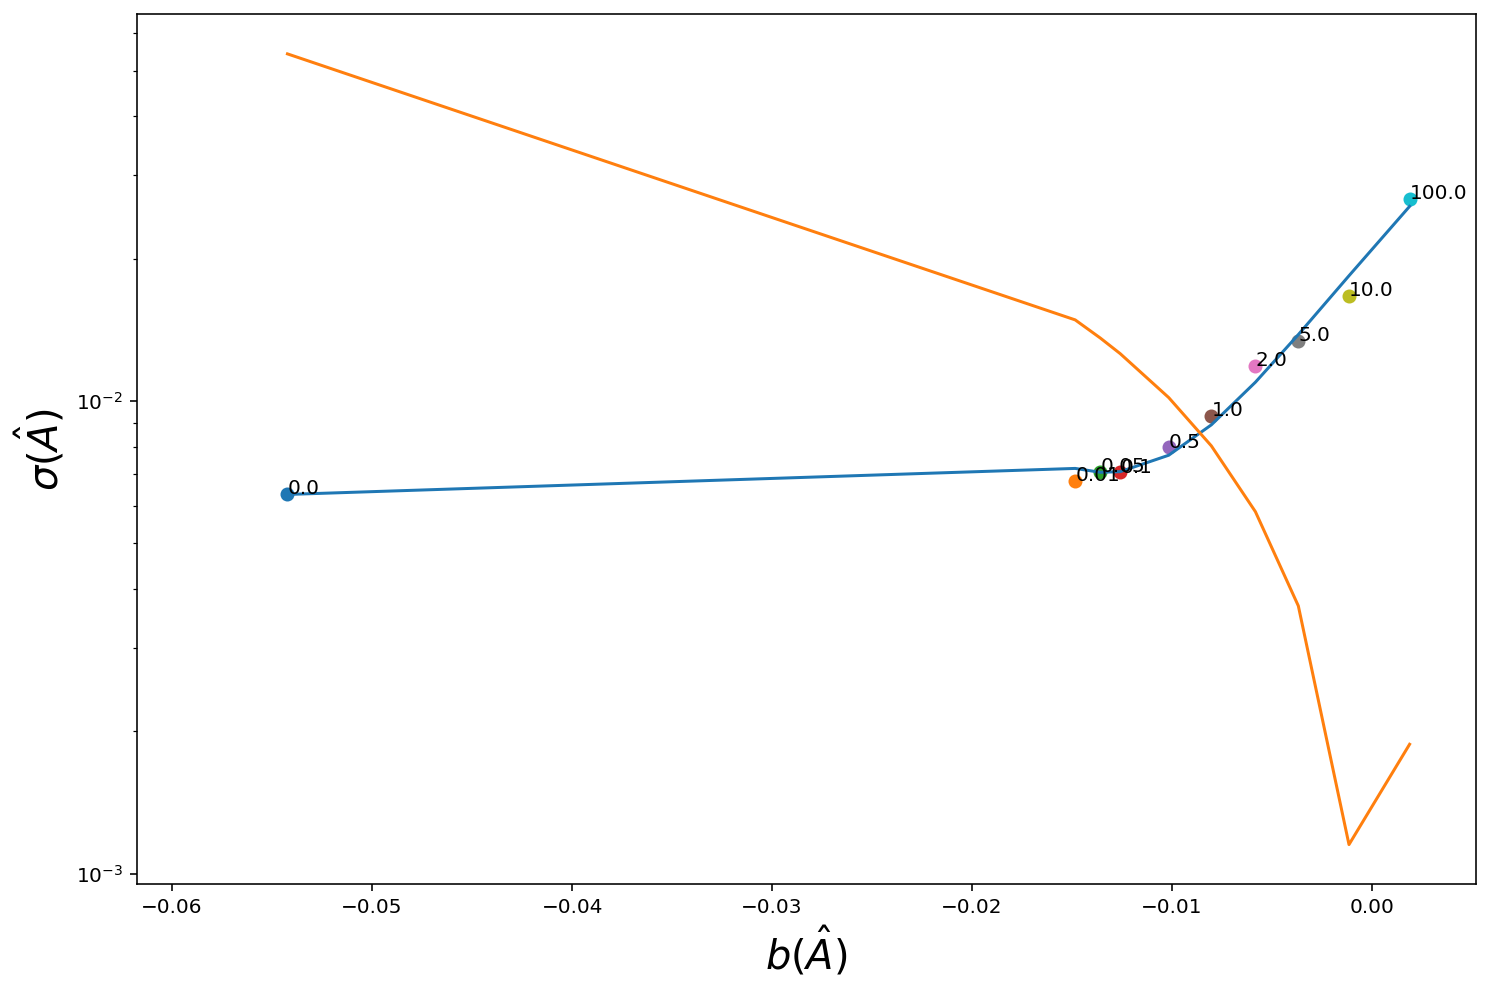

In [155]:
fig, ax = plt.subplots()

ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
ax.set_xlabel('$b(\hat{A})$', size = 20)

for i, c in enumerate(zip(bs, ns)):
    b, n = c
    ax.scatter(b, n)
    ax.annotate(fbs[i], (b, n))

p = np.poly1d(np.polyfit(bs, ns, 3))
plt.plot(bs, p(bs))
#ax.legend(loc = 'best')

ax.plot(bs, abs(bs))
#plt.plot(-ns, abs(ns))
plt.yscale('log')

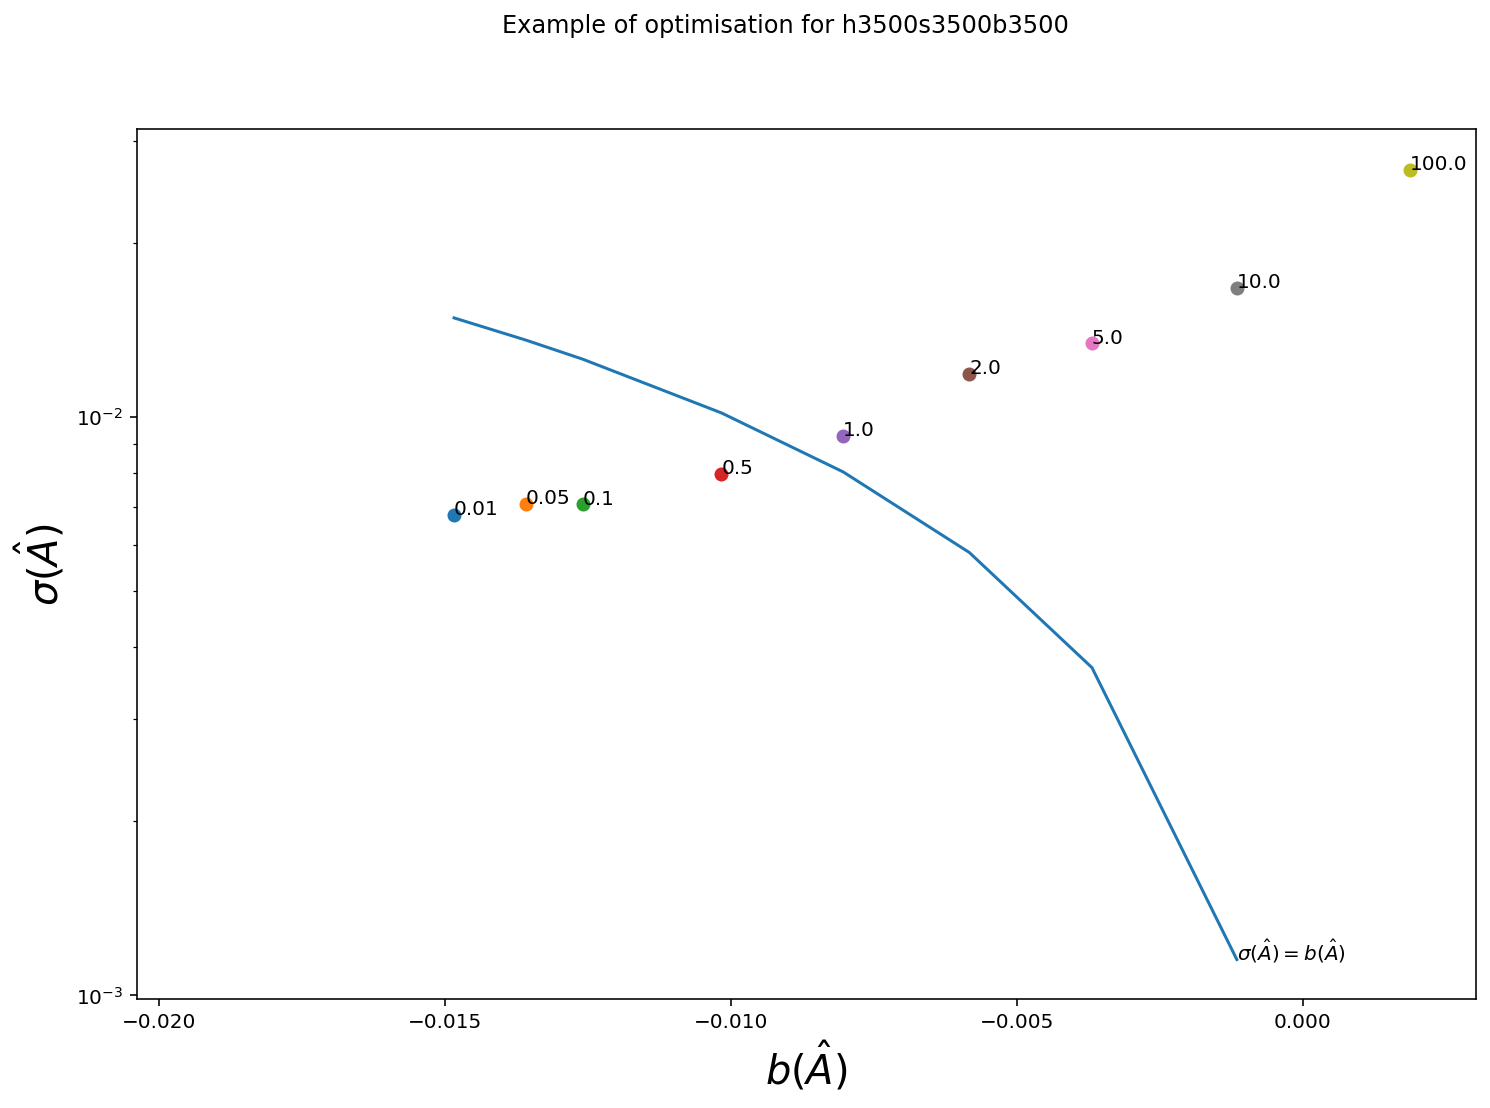

In [103]:
fig, ax = plt.subplots()

fig.suptitle(f'Example of optimisation for {lmax_directory}')

ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
ax.set_xlabel('$b(\hat{A})$', size = 20)

bottom = 1

for i, c in enumerate(zip(bs[bottom:], ns[bottom:])):
    b, n = c
    ax.scatter(b, n)
    ax.annotate(fbs[i+bottom], (b, n))

#ax.legend(loc = 'best')

ax.plot(bs[bottom:-1], abs(bs[bottom:-1]))
ax.annotate('$\\sigma(\hat{A}) = b(\hat{A})$', (bs[-2], abs(bs[-2])))
#plt.plot(-ns, abs(ns))
plt.yscale('log')

In [127]:
def get_corresponding_b_n(fb):
    index = list(fbs).index(fb)
    return bs[index], ns[index]


def reldifference(fb1, fb2):
    b1, n1 = get_corresponding_b_n(fb1)
    b2, n2 = get_corresponding_b_n(fb2)
    return abs(b1-b2)/abs(b1)*100, abs(n1-n2)/n1*100

In [97]:
get_corresponding_b_n(1.)

(-0.008035668755260038, 0.009288364460102285)

In [95]:
fb1, fb2 = 0., 1.
print(f'Relative difference between {fb1} {fb2} for bias and noise is {reldifference(fb1, fb2)}')

Relative difference between 0.0 1.0 for bias and noise is (85.18270965325472, 46.34233418811296)


In [96]:
fb1, fb2 = 0.1, 1.
print(f'Relative difference between {fb1} {fb2} for bias and noise is {reldifference(fb1, fb2)}')

Relative difference between 0.1 1.0 for bias and noise is (36.18558380488493, 31.570465224818705)


In [171]:
for fb in fbs:
    resultkk.load_all(directory, f'auto_fb_{fb}')
    d = resultkk.ws
    w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]

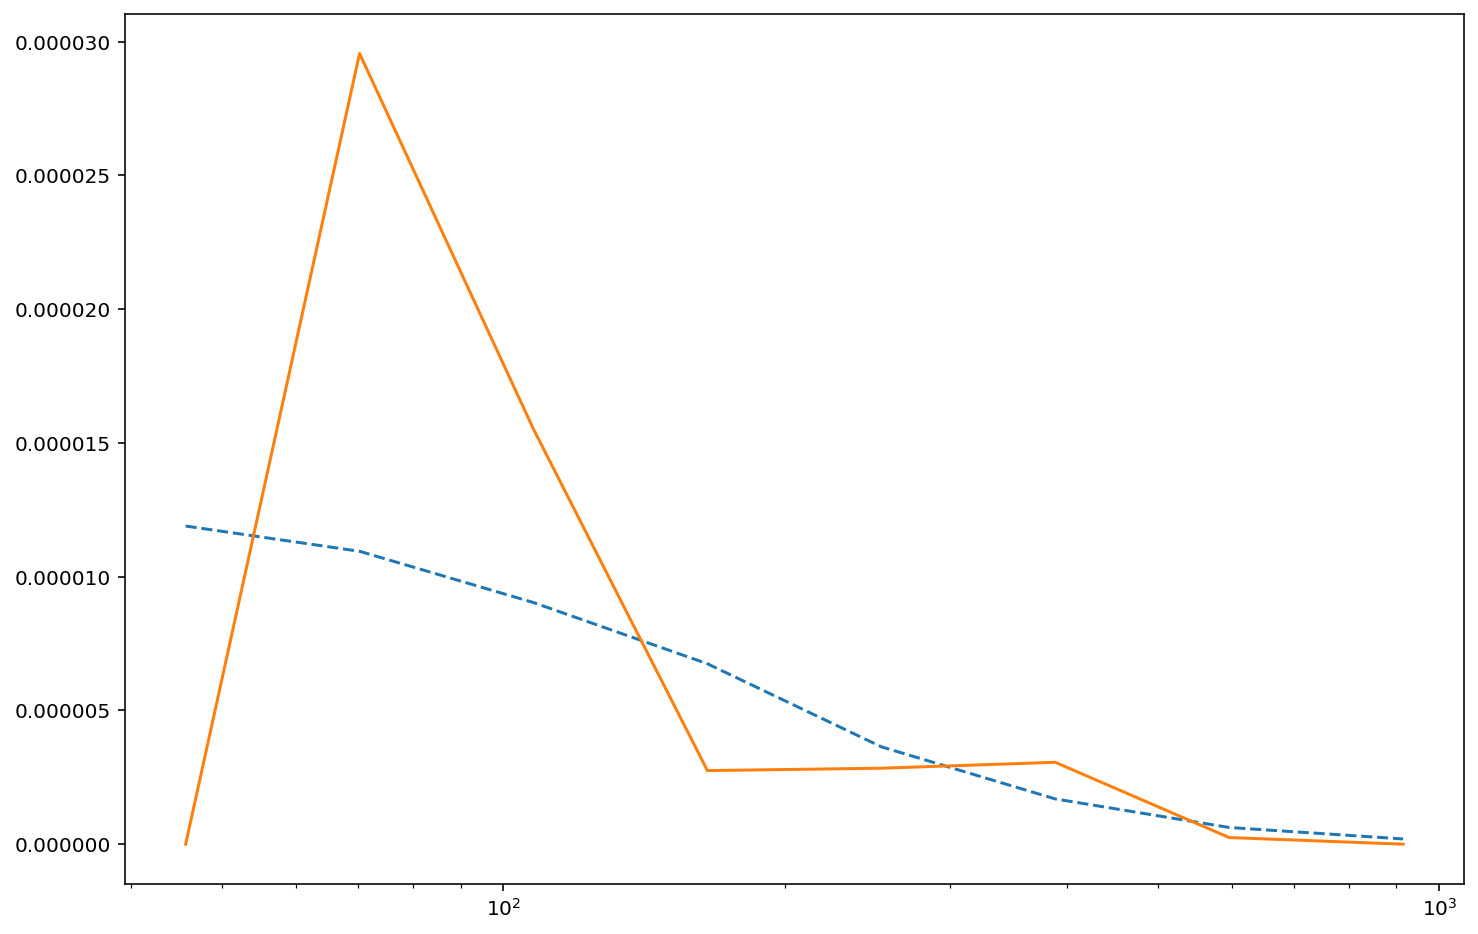

In [186]:
resultkk.load_all(directory, f'auto_fb_{0.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w, ls = '--')

resultkk.load_all(directory, f'auto_fb_{1.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w)

plt.xscale('log')

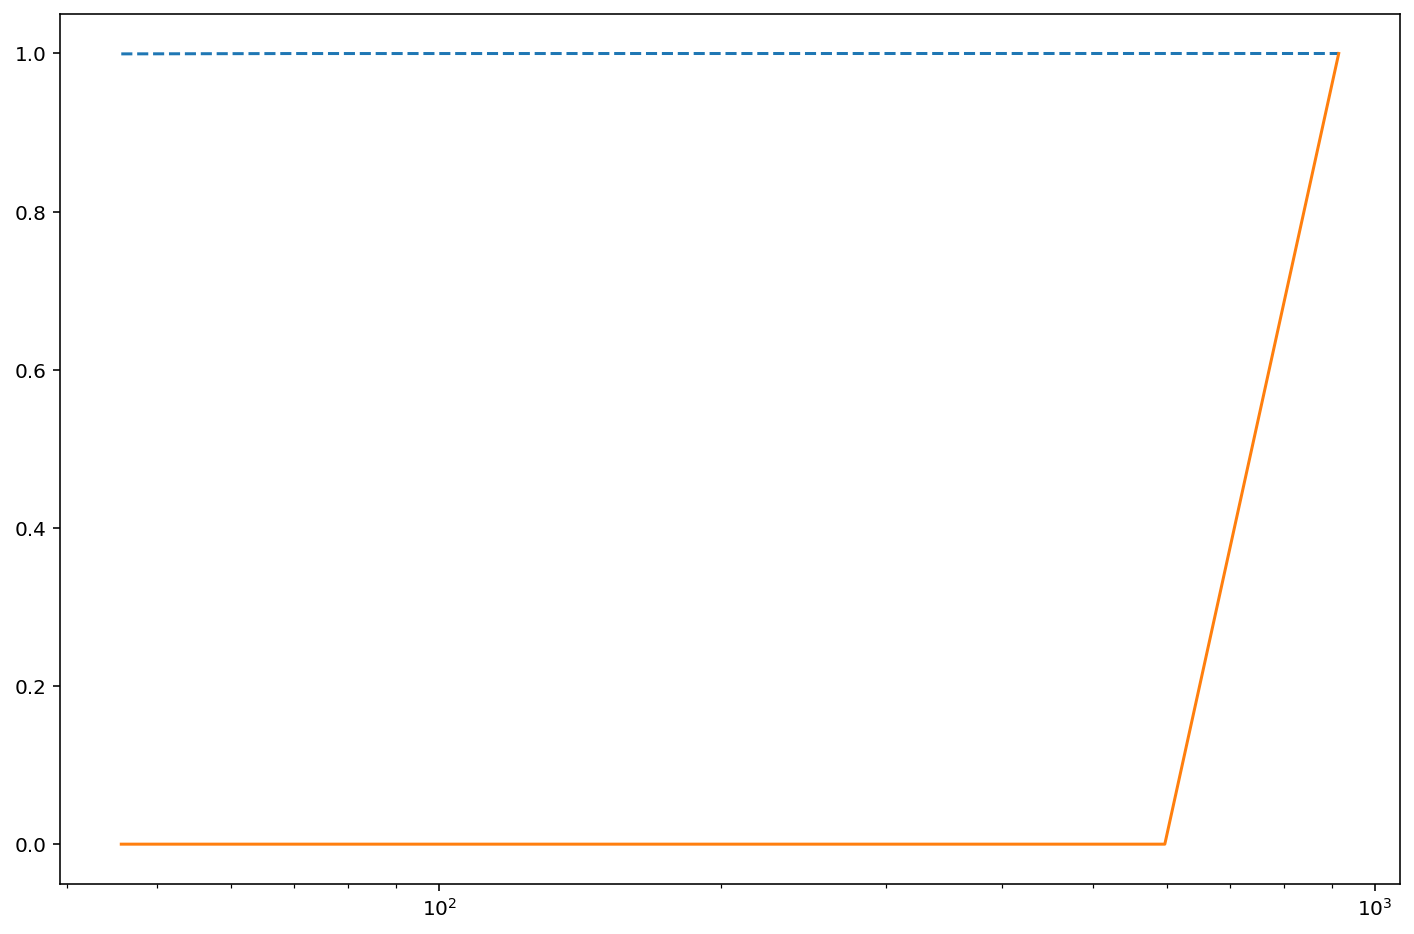

In [190]:
resultkk.load_all(directory, f'auto_fb_{0.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w1, ls = '--')

resultkk.load_all(directory, f'auto_fb_{.1}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w1)

plt.xscale('log')